# SETUP

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from warnings import filterwarnings
from scipy.optimize import minimize, Bounds, LinearConstraint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier,VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay,log_loss
import optuna

import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD, RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
from pytorch_tabnet.tab_model import TabNetClassifier

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

In [72]:
TRAIN_PROCESSED_PATH = '../data/processed/train_processed.csv'
TEST_PROCESSED_PATH = '../data/processed/test_processed.csv'
SAMPLE_SUBMISSION_PATH = '../data/example-submition.csv'

In [73]:
train_processed = pd.read_csv(TRAIN_PROCESSED_PATH)
test_processed = pd.read_csv(TEST_PROCESSED_PATH)
submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
LABEL = 'air quality'

In [74]:
X = train_processed.drop(LABEL, axis=1)
y = train_processed[LABEL]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [75]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weight))
class_weight

{0: np.float64(0.597683974598431),
 1: np.float64(0.8452192287374538),
 2: np.float64(1.2003000750187547),
 3: np.float64(3.2193158953722336)}

In [76]:
def plot_feature_importance(model, X, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        importances = model.get_feature_importance()
    else:
        print(f"Model {model_name} does not have feature importances.")
        return
    
    sorted_idx = np.argsort(importances)
    plt.figure(figsize=(15,10))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx])
    plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
    plt.title(f'Feature Importances from {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

In [77]:
models_without_cw = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, verbose=0),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

In [78]:
def cross_validate(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores, acc_scores = [], []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}")
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)

        f1 = f1_score(y_val_fold, y_pred, average='weighted')
        acc = accuracy_score(y_val_fold, y_pred)

        f1_scores.append(f1)
        acc_scores.append(acc)
        print(f"F1 Score: {f1:.4f}, Accuracy: {acc:.4f}\n")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Average Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
    return np.mean(f1_scores), np.mean(acc_scores)


Model: Logistic Regression
Model Logistic Regression does not have feature importances.
Fold 1
F1 Score: 0.9120, Accuracy: 0.9125

Fold 2
F1 Score: 0.9123, Accuracy: 0.9137

Fold 3
F1 Score: 0.9061, Accuracy: 0.9075

Fold 4
F1 Score: 0.9228, Accuracy: 0.9237

Fold 5
F1 Score: 0.9057, Accuracy: 0.9075

Average F1 Score: 0.9118 ± 0.0062
Average Accuracy: 0.9130 ± 0.0059
--------------------------------------------------
Model: SVC
Model SVC does not have feature importances.
Fold 1
F1 Score: 0.9141, Accuracy: 0.9144

Fold 2
F1 Score: 0.9160, Accuracy: 0.9175

Fold 3
F1 Score: 0.9135, Accuracy: 0.9144

Fold 4
F1 Score: 0.9272, Accuracy: 0.9281

Fold 5
F1 Score: 0.9133, Accuracy: 0.9150

Average F1 Score: 0.9168 ± 0.0053
Average Accuracy: 0.9179 ± 0.0053
--------------------------------------------------
Model: Decision Tree


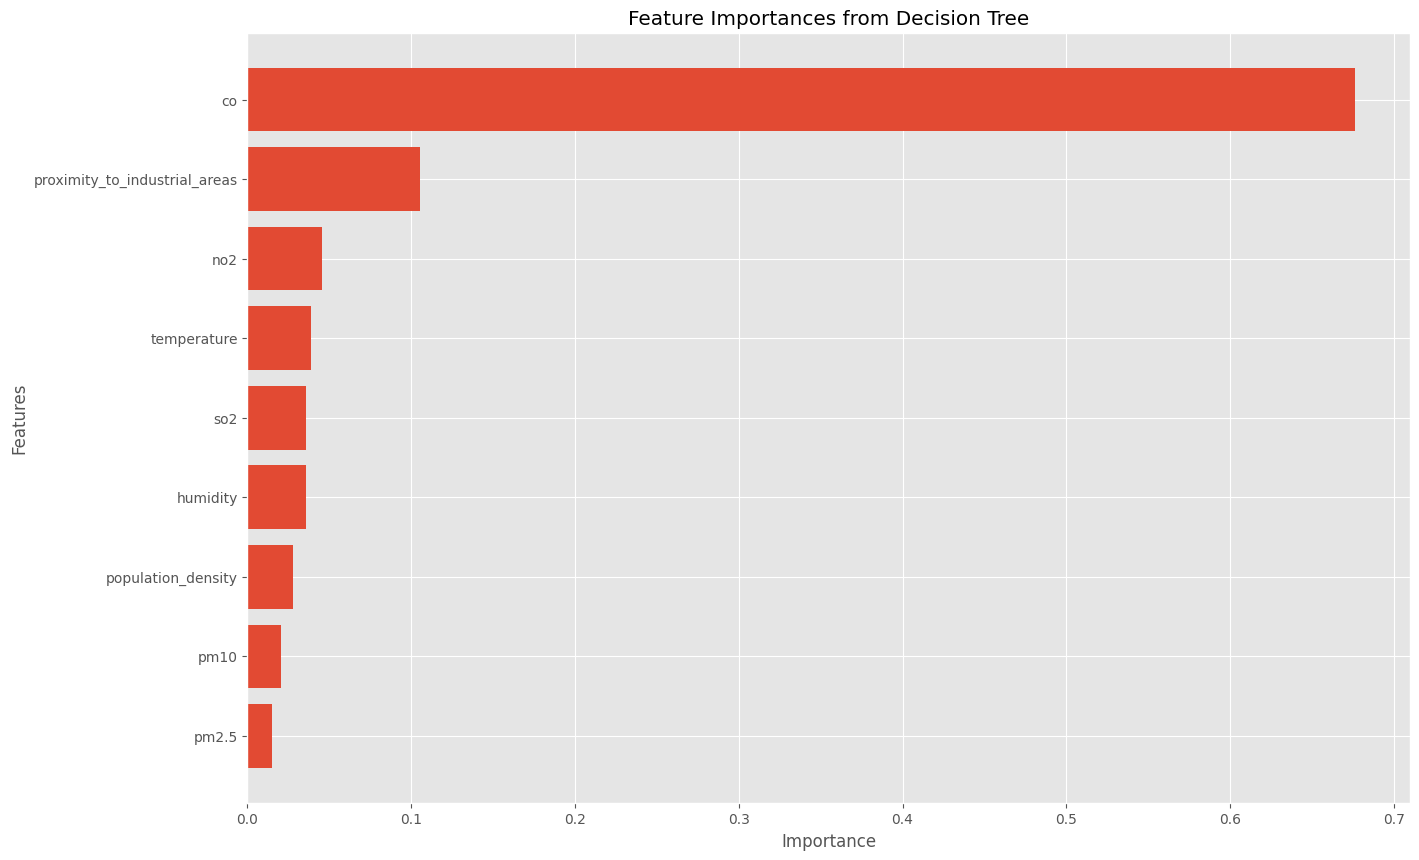

Fold 1
F1 Score: 0.8798, Accuracy: 0.8794

Fold 2
F1 Score: 0.8802, Accuracy: 0.8812

Fold 3
F1 Score: 0.8678, Accuracy: 0.8675

Fold 4
F1 Score: 0.8738, Accuracy: 0.8738

Fold 5
F1 Score: 0.8744, Accuracy: 0.8738

Average F1 Score: 0.8752 ± 0.0045
Average Accuracy: 0.8751 ± 0.0048
--------------------------------------------------
Model: Random Forest


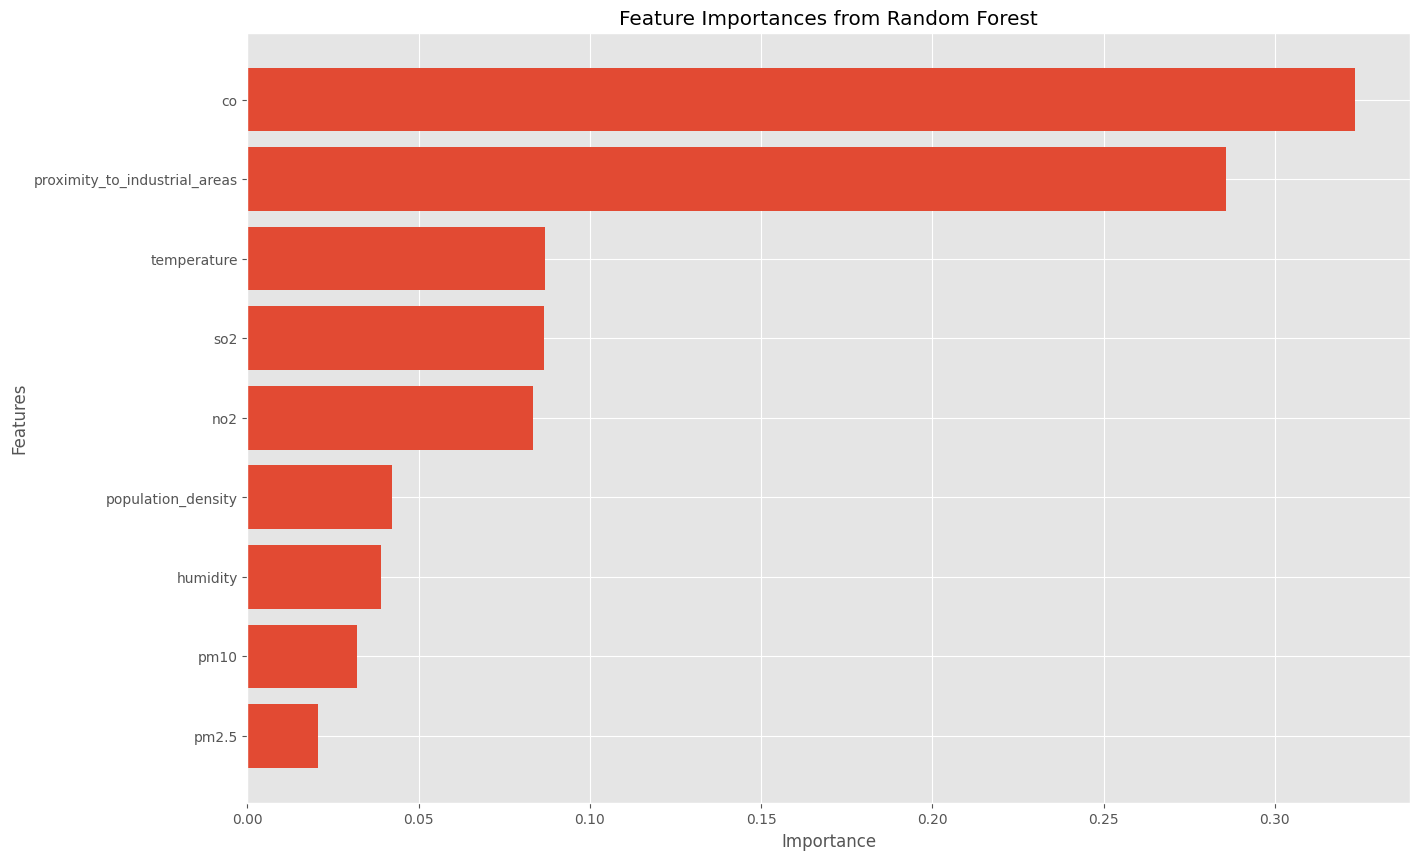

Fold 1
F1 Score: 0.9156, Accuracy: 0.9163

Fold 2
F1 Score: 0.9136, Accuracy: 0.9156

Fold 3
F1 Score: 0.9180, Accuracy: 0.9187

Fold 4
F1 Score: 0.9139, Accuracy: 0.9150

Fold 5
F1 Score: 0.9096, Accuracy: 0.9113

Average F1 Score: 0.9142 ± 0.0028
Average Accuracy: 0.9154 ± 0.0024
--------------------------------------------------
Model: Gradient Boosting


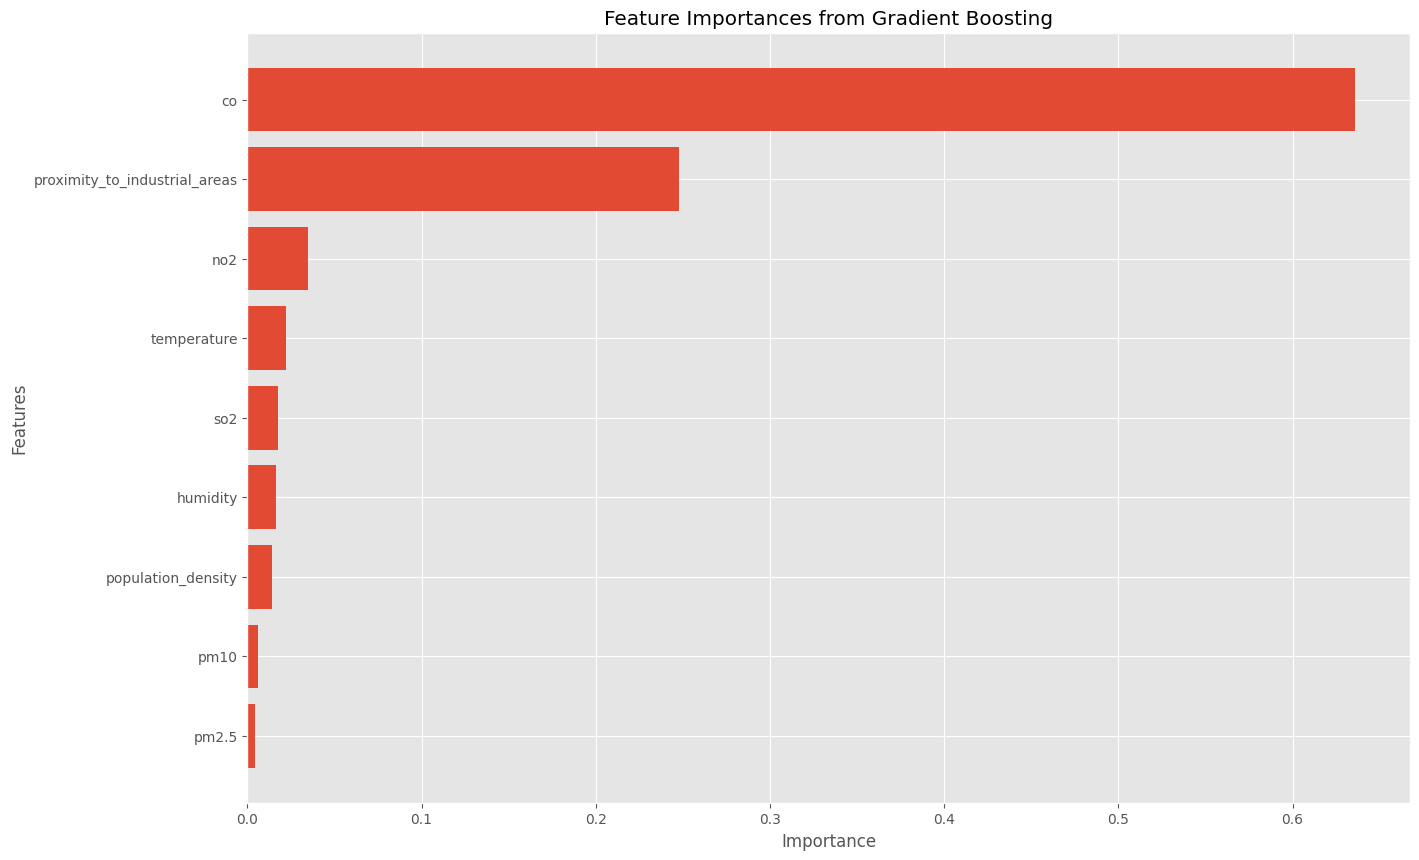

Fold 1
F1 Score: 0.9178, Accuracy: 0.9181

Fold 2
F1 Score: 0.9139, Accuracy: 0.9150

Fold 3
F1 Score: 0.9199, Accuracy: 0.9206

Fold 4
F1 Score: 0.9154, Accuracy: 0.9163

Fold 5
F1 Score: 0.9109, Accuracy: 0.9131

Average F1 Score: 0.9156 ± 0.0031
Average Accuracy: 0.9166 ± 0.0026
--------------------------------------------------
Model: XGBoost


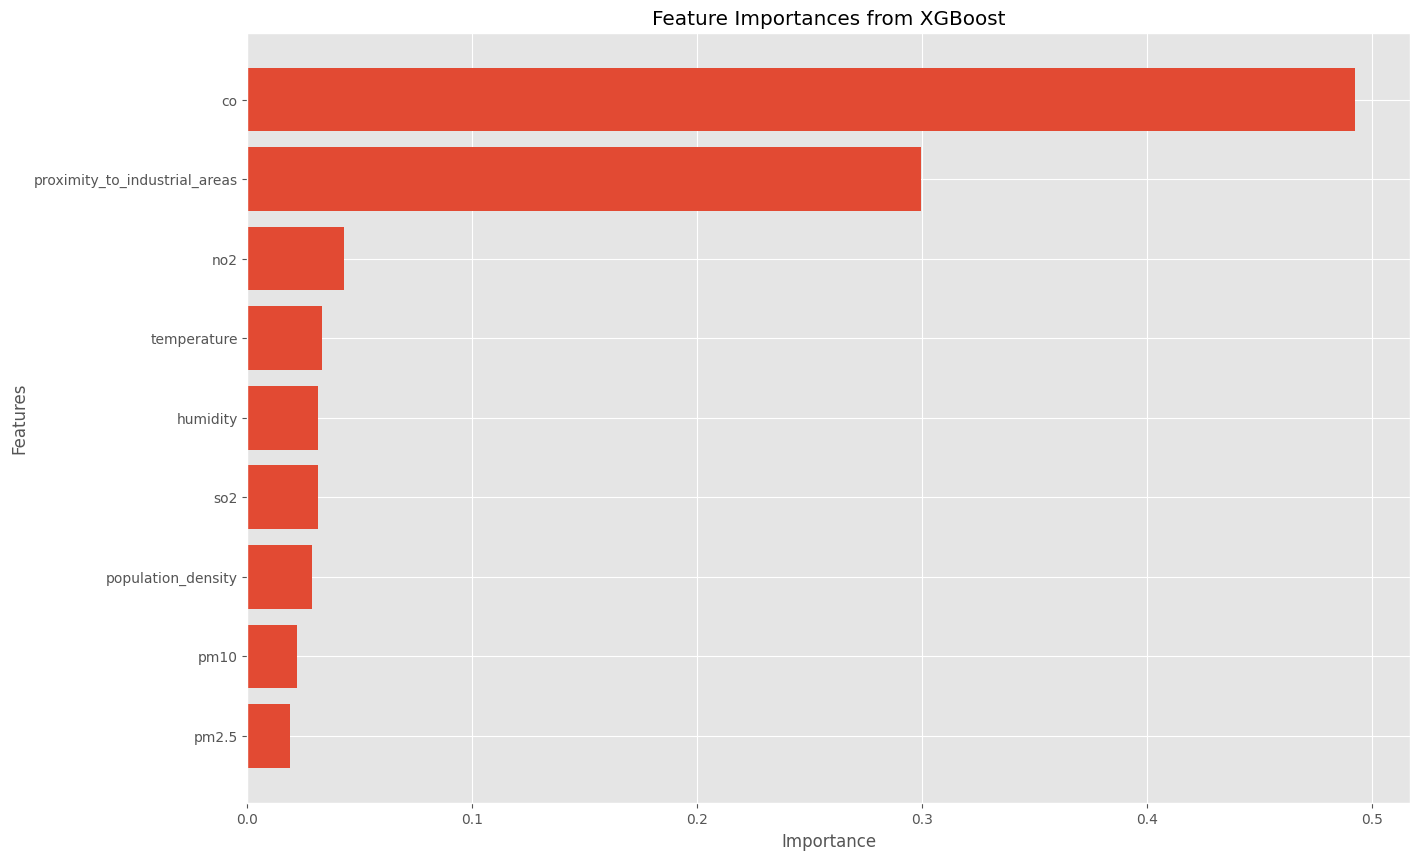

Fold 1
F1 Score: 0.9154, Accuracy: 0.9156

Fold 2
F1 Score: 0.9126, Accuracy: 0.9137

Fold 3
F1 Score: 0.9168, Accuracy: 0.9175

Fold 4
F1 Score: 0.9131, Accuracy: 0.9137

Fold 5
F1 Score: 0.9083, Accuracy: 0.9094

Average F1 Score: 0.9132 ± 0.0029
Average Accuracy: 0.9140 ± 0.0027
--------------------------------------------------
Model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2196
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 9
[LightGBM] [Info] Start training from score -0.871676
[LightGBM] [Info] Start training from score -1.217818
[LightGBM] [Info] Start training from score -1.569016
[LightGBM] [Info] Start training from score -2.555866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


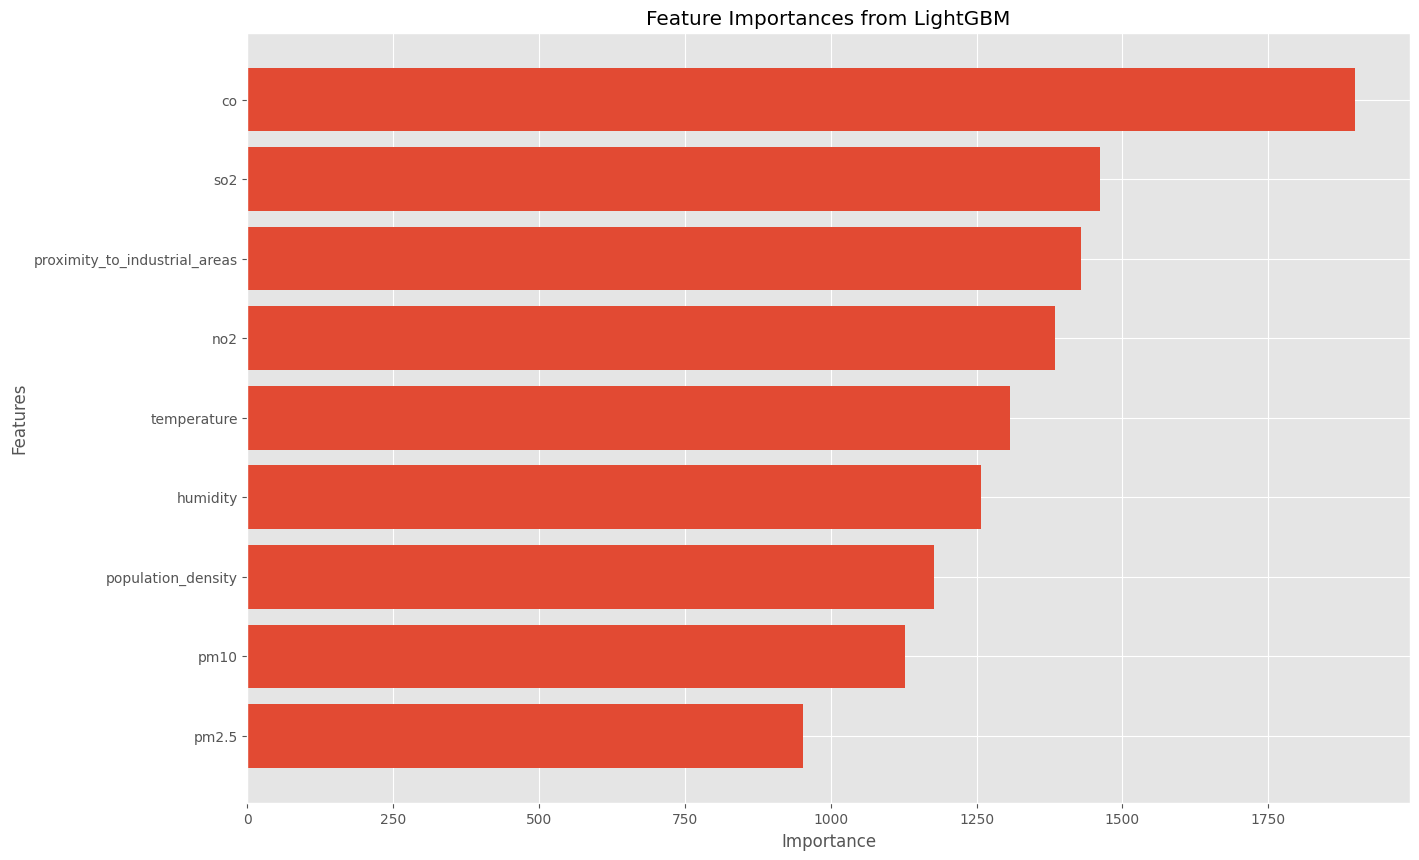

Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2175
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 9
[LightGBM] [Info] Start training from score -0.871975
[LightGBM] [Info] Start training from score -1.217607
[LightGBM] [Info] Start training from score -1.568866
[LightGBM] [Info] Start training from score -2.555463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
F1 Score: 0.9134, Accuracy: 0.9137

Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 9
[LightGBM] [Info] Start training from score -0.871601
[LightGBM] [Info] Start trainin

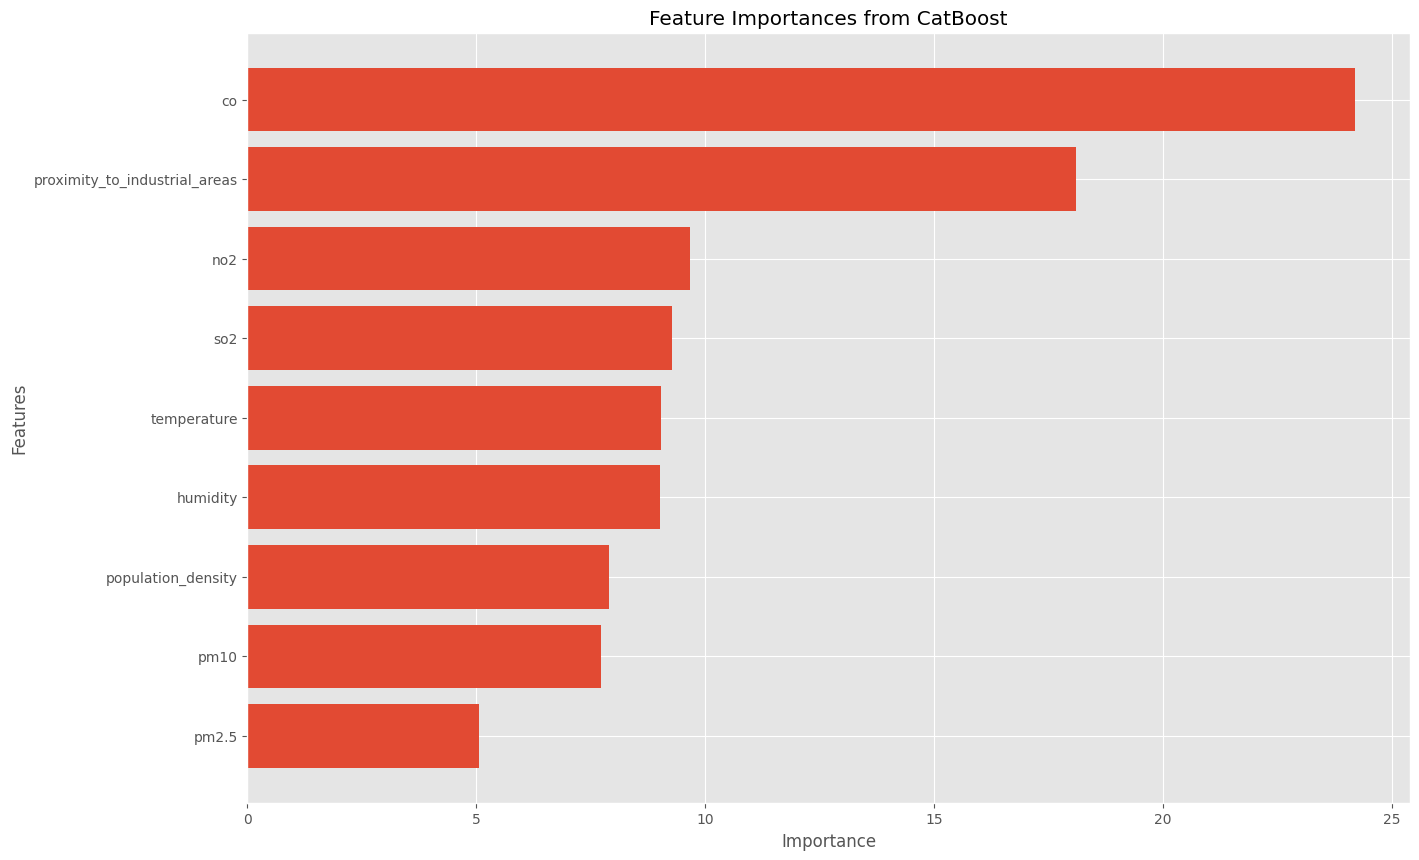

Fold 1
F1 Score: 0.9185, Accuracy: 0.9187

Fold 2
F1 Score: 0.9142, Accuracy: 0.9156

Fold 3
F1 Score: 0.9181, Accuracy: 0.9187

Fold 4
F1 Score: 0.9210, Accuracy: 0.9219

Fold 5
F1 Score: 0.9166, Accuracy: 0.9175

Average F1 Score: 0.9177 ± 0.0023
Average Accuracy: 0.9185 ± 0.0020
--------------------------------------------------


,Model,F1 Score,Accuracy
0,CatBoost,0.917669,0.918500
1,SVC,0.916823,0.917875
2,Gradient Boosting,0.915575,0.916625
3,Random Forest,0.914152,0.915375
4,LightGBM,0.913256,0.914250
5,XGBoost,0.913232,0.914000
6,Logistic Regression,0.911785,0.913000
7,Decision Tree,0.875200,0.875125


In [79]:
def modeling(models, X, y):
    name_l, f1_s, acc_s = [], [], []
    scores_df = pd.DataFrame()
    for name, model in models.items():
        print(f"Model: {name}")
        model.fit(X, y)
        plot_feature_importance(model, X, name)
        f1, acc = cross_validate(model, X, y, n_splits=5)
        name_l.append(name)
        f1_s.append(f1)
        acc_s.append(acc)
        print("-" * 50)
    scores_df['Model'] = name_l
    scores_df['F1 Score'] = f1_s
    scores_df['Accuracy'] = acc_s
    return scores_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

display(modeling(models_without_cw, X, y))

In [81]:
models_with_cw = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weight),
    'SVC': SVC(random_state=42, class_weight=class_weight),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight=class_weight),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=None, verbose=0),
    'LightGBM': LGBMClassifier(random_state=42, class_weight=class_weight),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, class_weights=list(class_weight.values()))
}

Model: Logistic Regression
Model Logistic Regression does not have feature importances.
Fold 1
F1 Score: 0.9029, Accuracy: 0.9019

Fold 2
F1 Score: 0.9129, Accuracy: 0.9125

Fold 3
F1 Score: 0.9069, Accuracy: 0.9062

Fold 4
F1 Score: 0.9215, Accuracy: 0.9206

Fold 5
F1 Score: 0.9080, Accuracy: 0.9075

Average F1 Score: 0.9104 ± 0.0064
Average Accuracy: 0.9098 ± 0.0064
--------------------------------------------------
Model: SVC
Model SVC does not have feature importances.
Fold 1
F1 Score: 0.9074, Accuracy: 0.9062

Fold 2
F1 Score: 0.9142, Accuracy: 0.9137

Fold 3
F1 Score: 0.9050, Accuracy: 0.9050

Fold 4
F1 Score: 0.9194, Accuracy: 0.9187

Fold 5
F1 Score: 0.9082, Accuracy: 0.9075

Average F1 Score: 0.9108 ± 0.0052
Average Accuracy: 0.9102 ± 0.0052
--------------------------------------------------
Model: Decision Tree


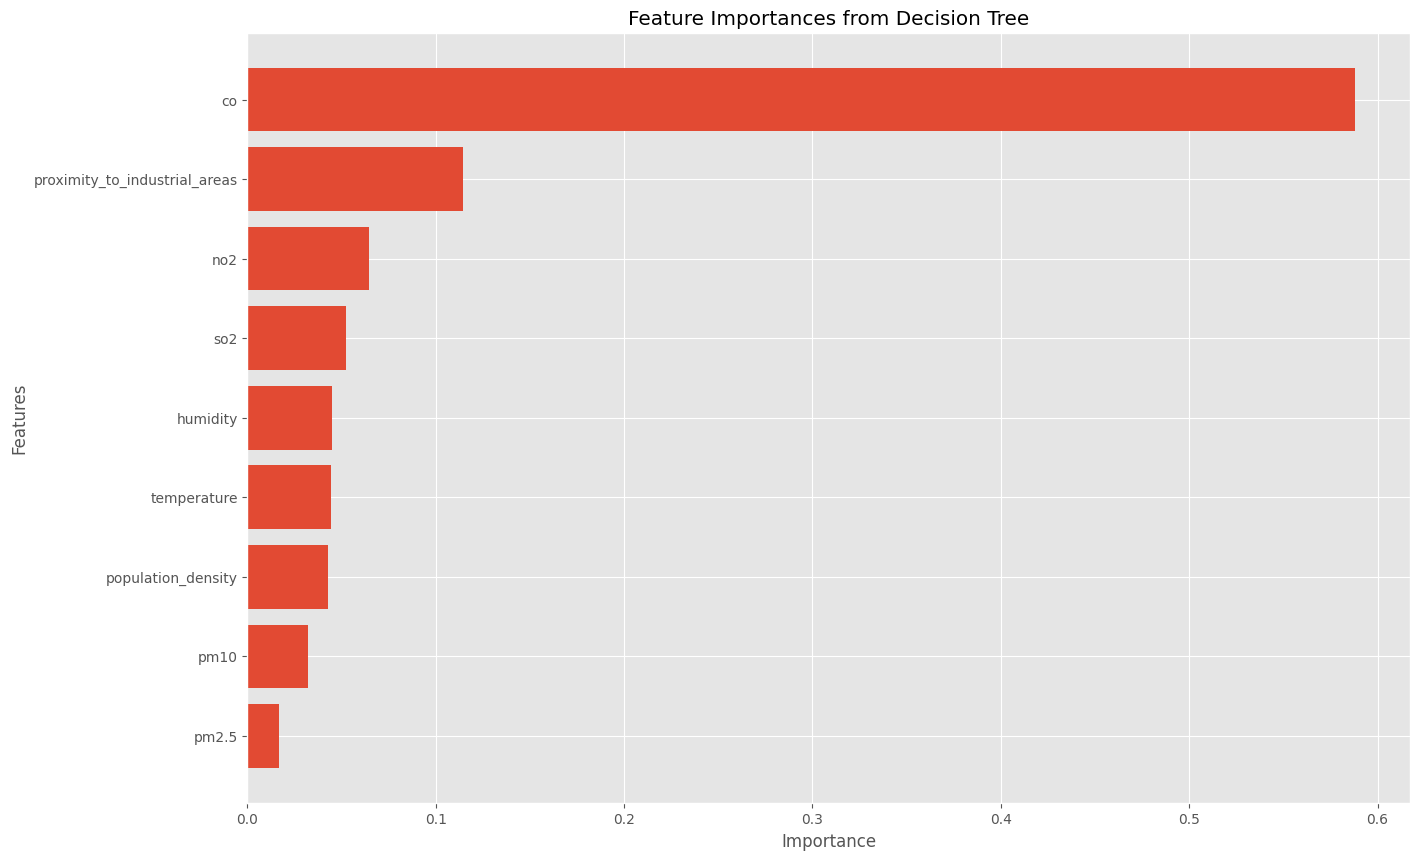

Fold 1
F1 Score: 0.8745, Accuracy: 0.8744

Fold 2
F1 Score: 0.8776, Accuracy: 0.8788

Fold 3
F1 Score: 0.8626, Accuracy: 0.8619

Fold 4
F1 Score: 0.8674, Accuracy: 0.8669

Fold 5
F1 Score: 0.8702, Accuracy: 0.8706

Average F1 Score: 0.8705 ± 0.0053
Average Accuracy: 0.8705 ± 0.0058
--------------------------------------------------
Model: Random Forest


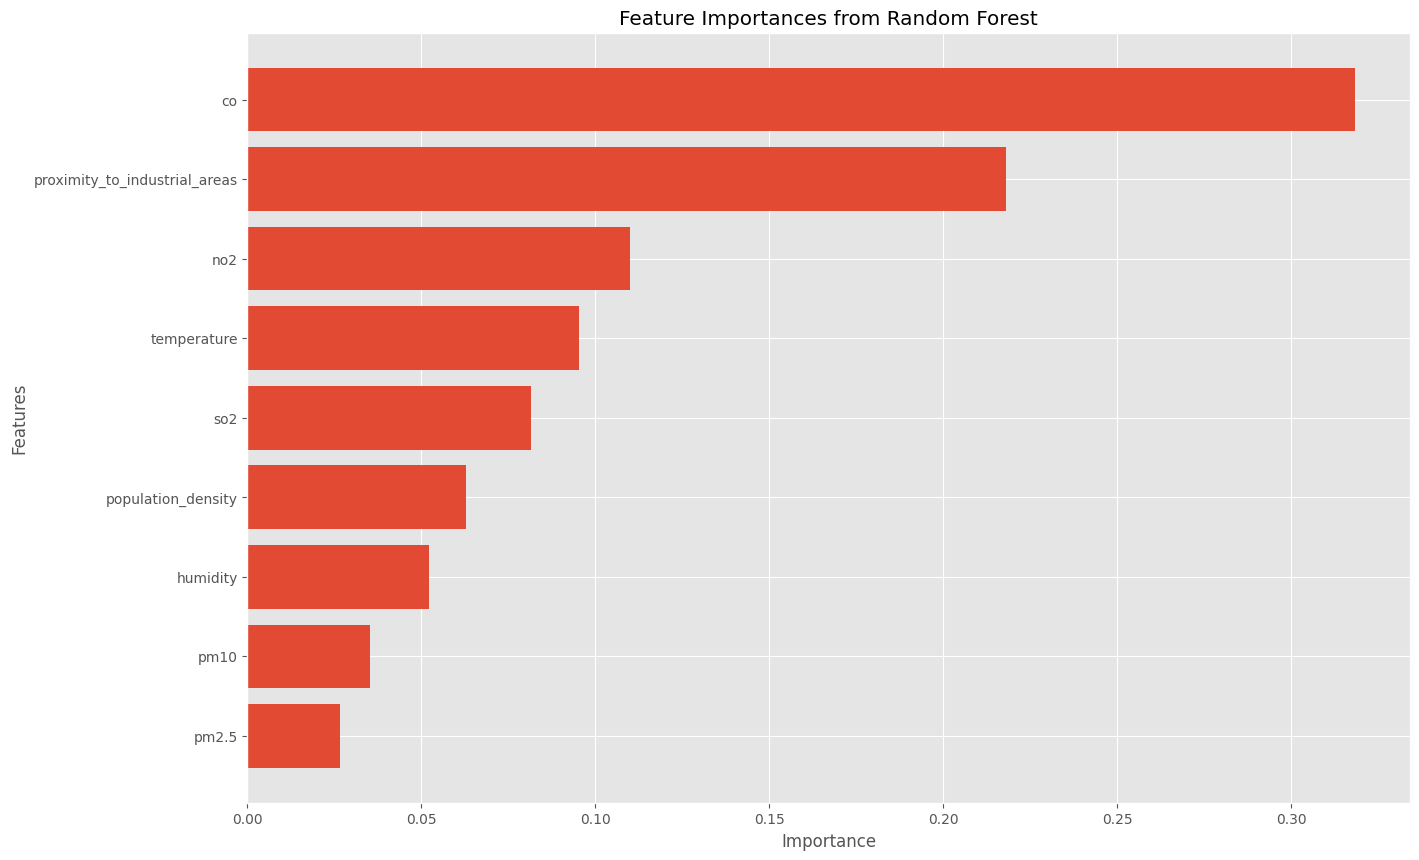

Fold 1
F1 Score: 0.9103, Accuracy: 0.9113

Fold 2
F1 Score: 0.9071, Accuracy: 0.9094

Fold 3
F1 Score: 0.9130, Accuracy: 0.9144

Fold 4
F1 Score: 0.9118, Accuracy: 0.9137

Fold 5
F1 Score: 0.9101, Accuracy: 0.9125

Average F1 Score: 0.9105 ± 0.0020
Average Accuracy: 0.9123 ± 0.0018
--------------------------------------------------
Model: Gradient Boosting


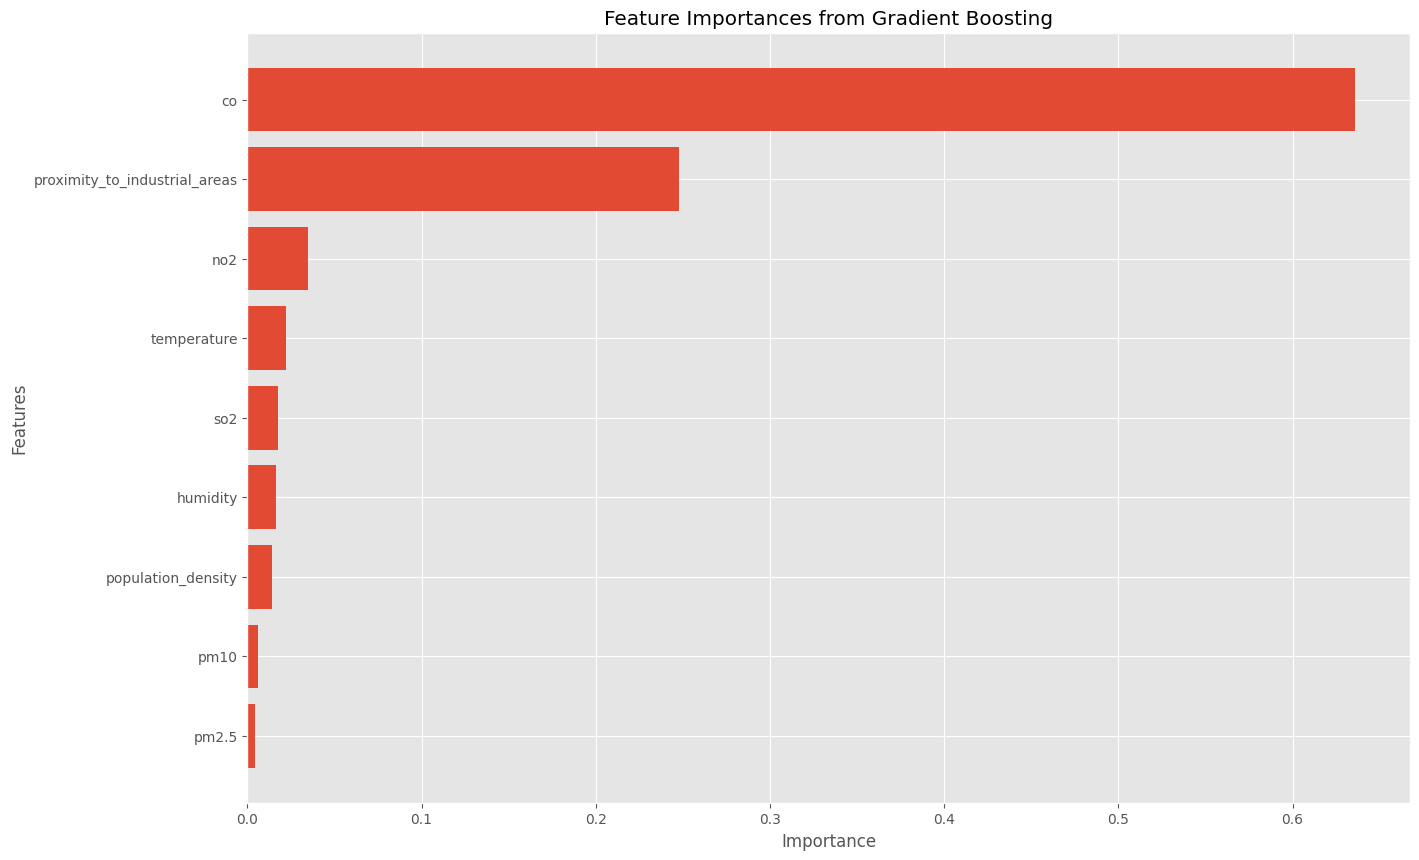

Fold 1
F1 Score: 0.9178, Accuracy: 0.9181

Fold 2
F1 Score: 0.9139, Accuracy: 0.9150

Fold 3
F1 Score: 0.9199, Accuracy: 0.9206

Fold 4
F1 Score: 0.9154, Accuracy: 0.9163

Fold 5
F1 Score: 0.9109, Accuracy: 0.9131

Average F1 Score: 0.9156 ± 0.0031
Average Accuracy: 0.9166 ± 0.0026
--------------------------------------------------
Model: XGBoost


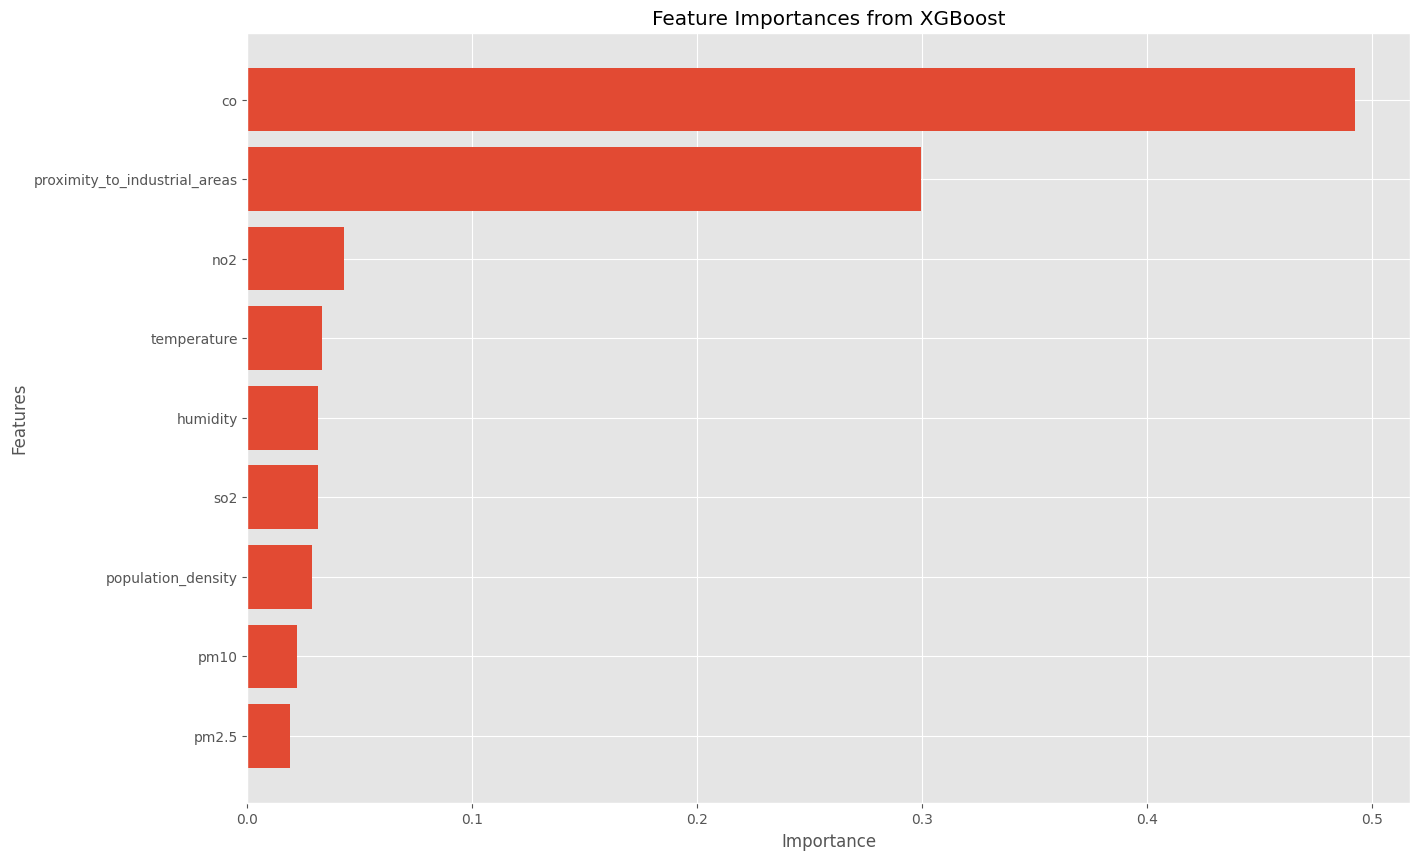

Fold 1
F1 Score: 0.9154, Accuracy: 0.9156

Fold 2
F1 Score: 0.9126, Accuracy: 0.9137

Fold 3
F1 Score: 0.9168, Accuracy: 0.9175

Fold 4
F1 Score: 0.9131, Accuracy: 0.9137

Fold 5
F1 Score: 0.9083, Accuracy: 0.9094

Average F1 Score: 0.9132 ± 0.0029
Average Accuracy: 0.9140 ± 0.0027
--------------------------------------------------
Model: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2196
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 9
[LightGBM] [Info] Start training from score -1.386292
[LightGBM] [Info] Start training from score -1.385900
[LightGBM] [Info] Start training from score -1.386367
[LightGBM] [Info] Start training from score -1.386619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


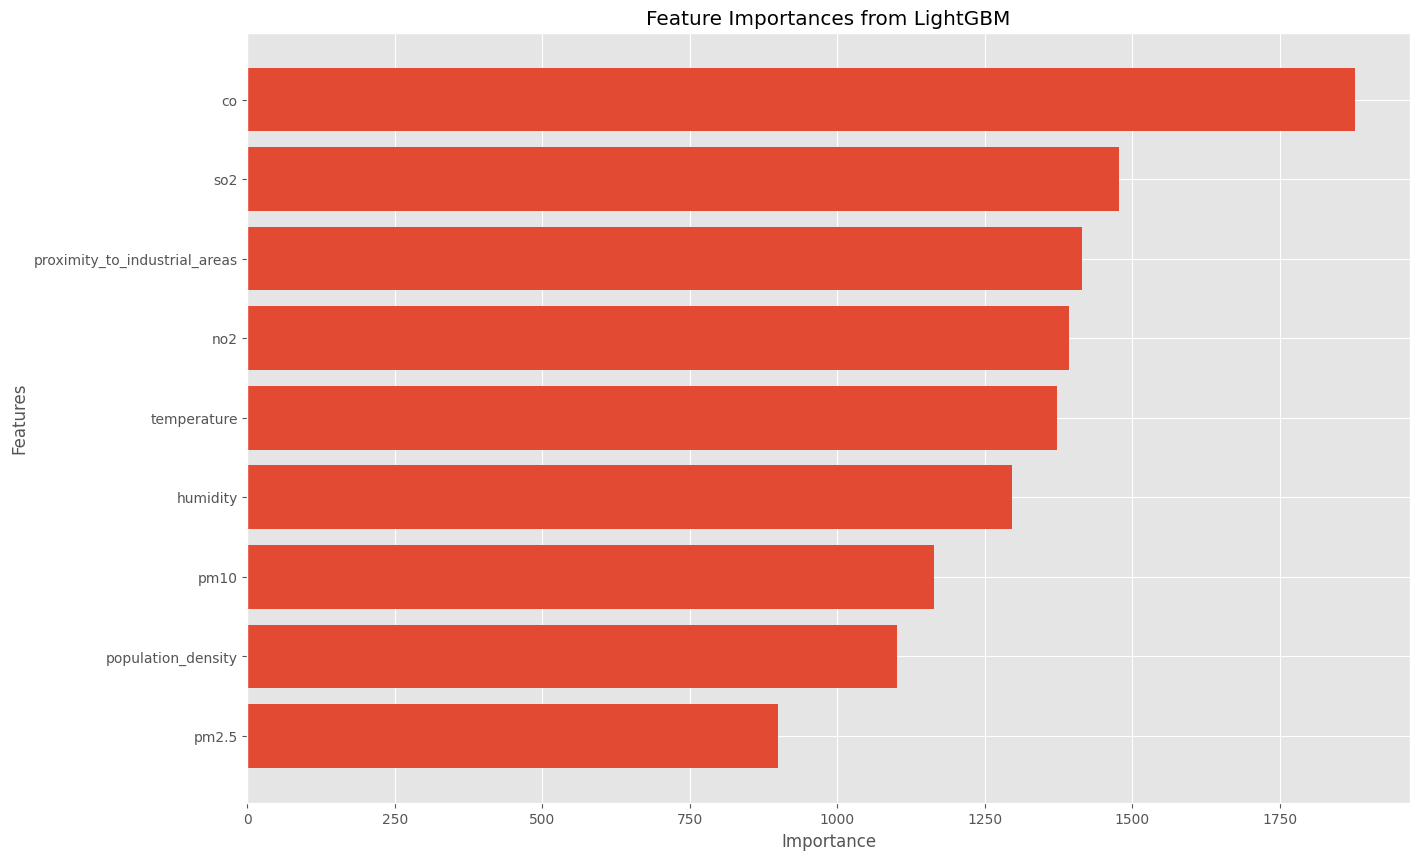

Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2175
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 9
[LightGBM] [Info] Start training from score -1.386707
[LightGBM] [Info] Start training from score -1.385805
[LightGBM] [Info] Start training from score -1.386333
[LightGBM] [Info] Start training from score -1.386333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
F1 Score: 0.9123, Accuracy: 0.9119

Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 9
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start trainin

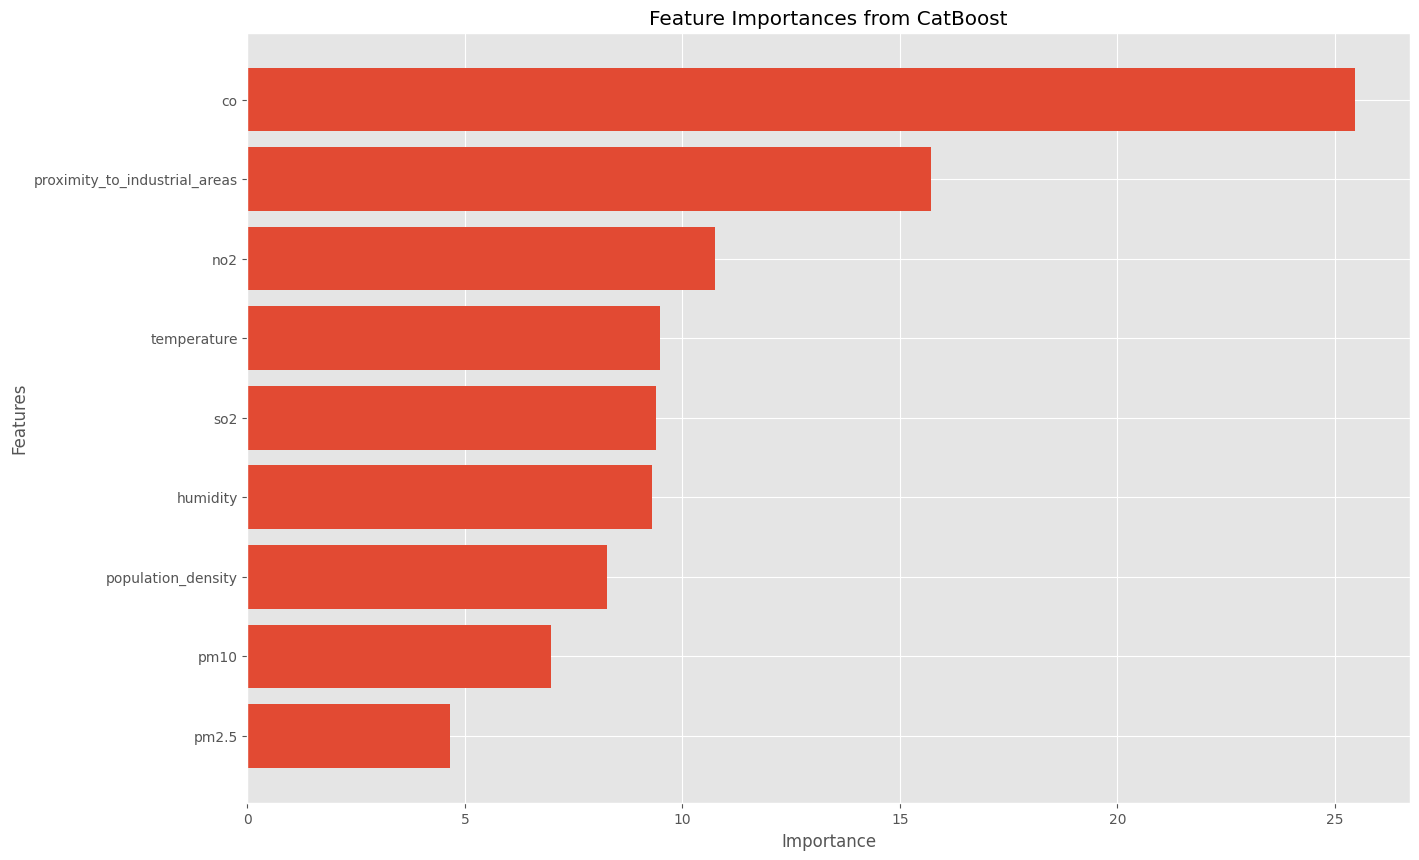

Fold 1
F1 Score: 0.9192, Accuracy: 0.9187

Fold 2
F1 Score: 0.9107, Accuracy: 0.9113

Fold 3
F1 Score: 0.9142, Accuracy: 0.9144

Fold 4
F1 Score: 0.9256, Accuracy: 0.9256

Fold 5
F1 Score: 0.9157, Accuracy: 0.9156

Average F1 Score: 0.9171 ± 0.0051
Average Accuracy: 0.9171 ± 0.0049
--------------------------------------------------


,Model,F1 Score,Accuracy
0,CatBoost,0.917073,0.917125
1,Gradient Boosting,0.915575,0.916625
2,LightGBM,0.915169,0.915375
3,XGBoost,0.913232,0.914000
4,SVC,0.910810,0.910250
5,Random Forest,0.910471,0.912250
6,Logistic Regression,0.910434,0.909750
7,Decision Tree,0.870455,0.870500


In [82]:
modeling(models_with_cw, X, y)

# ENSEMBLE LEARNING

## Base Vote

In [83]:
estimators = [
    ('catboost', CatBoostClassifier(random_state=42, verbose=0)),
    ('svc', SVC(random_state=42, probability=True)),
    ('gradient_boosting', GradientBoostingClassifier(random_state=42))
]

In [84]:
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
modeling({'Voting Classifier': voting_clf}, X, y)

Model: Voting Classifier
Model Voting Classifier does not have feature importances.
Fold 1
F1 Score: 0.9214, Accuracy: 0.9219

Fold 2
F1 Score: 0.9176, Accuracy: 0.9187

Fold 3
F1 Score: 0.9199, Accuracy: 0.9206

Fold 4
F1 Score: 0.9248, Accuracy: 0.9256

Fold 5
F1 Score: 0.9168, Accuracy: 0.9187

Average F1 Score: 0.9201 ± 0.0029
Average Accuracy: 0.9211 ± 0.0025
--------------------------------------------------


,Model,F1 Score,Accuracy
0,Voting Classifier,0.920125,0.921125


## Vote + Optimized Weights (SLSQP)

In [88]:
def get_optimize_weight_slsqp(all_preds, y_true):
    """
    Optimasi bobot ensemble untuk Multiclass Classification.
    
    all_preds: List of numpy arrays. 
               Setiap array harus berukuran (n_samples, n_classes).
    y_true:    Array label asli (n_samples,).
    """
    n_models = len(all_preds)
    
    # --- 1. Konversi ke Numpy Array 3D agar komputasi cepat ---
    # Shape menjadi: (n_models, n_samples, n_classes)
    predictions_array = np.array(all_preds)
    
    def loss_func(weights):
        # --- 2. Weighted Average menggunakan Broadcasting ---
        # Mengalikan (n_models, 1, 1) dengan (n_models, n_samples, n_classes)
        # Lalu dijumlahkan di axis model (axis 0)
        final_pred = np.sum(predictions_array * weights[:, None, None], axis=0)
        
        # Normalisasi (Safety net, meski constraint sudah menjamin sum=1)
        final_pred /= np.sum(weights)
        
        # Clip agar tidak log(0)
        final_pred = np.clip(final_pred, 1e-15, 1-1e-15)
        
        # Log Loss otomatis handle multiclass
        return log_loss(y_true, final_pred)
    
    # Inisialisasi bobot rata
    initial_weights = np.ones(n_models) / n_models
    
    # --- 3. Definisi Bounds dan Constraints (Style SLSQP Standar) ---
    # Bounds: Tiap bobot antara 0 dan 1
    # Format list of tuples [(0,1), (0,1), ...] lebih aman untuk minimize()
    bounds = [(0, 1)] * n_models
    
    # Constraints: Sum(weights) = 1
    constraints = ({'type': 'eq', 'fun': lambda w: 1 - np.sum(w)})
    
    result = minimize(
        loss_func, 
        initial_weights, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    
    return result.x

# --- Simulasi Penggunaan (Multiclass) ---
# Misal ada 3 Kelas (0, 1, 2)

all_pred = []
# Asumsi 'estimators' adalah list tuple (name, model)
# X_val, y_val sudah terdefinisi

# Pastikan loop ini berjalan sebelum fungsi dipanggil
for name, model in estimators:
   model.fit(X_train, y_train)
   preds = model.predict_proba(X_val) # Output shape: (n_samples, 3)
   all_pred.append(preds)

optimal_weights = get_optimize_weight_slsqp(all_pred, y_val)

In [89]:
optimal_weights_slsqp = optimal_weights
optimal_weights_slsqp

array([0.27881927, 0.3925415 , 0.32863923])

In [90]:
vote_w = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=optimal_weights
)
modeling({'Weighted Voting Classifier': vote_w}, X, y)

Model: Weighted Voting Classifier
Model Weighted Voting Classifier does not have feature importances.
Fold 1
F1 Score: 0.9220, Accuracy: 0.9225

Fold 2
F1 Score: 0.9162, Accuracy: 0.9175

Fold 3
F1 Score: 0.9224, Accuracy: 0.9231

Fold 4
F1 Score: 0.9242, Accuracy: 0.9250

Fold 5
F1 Score: 0.9182, Accuracy: 0.9200

Average F1 Score: 0.9206 ± 0.0029
Average Accuracy: 0.9216 ± 0.0026
--------------------------------------------------


,Model,F1 Score,Accuracy
0,Weighted Voting Classifier,0.920591,0.921625


## Snippet Optuna

In [43]:
def objective(trial):
    # Suggest weights
    weights = []
    for i in range(len(all_pred)):
        weights.append(trial.suggest_float(f"w{i}", 0, 1))
    
    # Normalisasi agar sum=1
    weight_sum = sum(weights)
    weights = [w/weight_sum for w in weights]
    
    # Weighted Average
    # (Pastikan logic broadcasting sama seperti kode sebelumnya)
    final_pred = np.sum(np.array(all_pred) * np.array(weights)[:, None, None], axis=0)
    
    return log_loss(y_val, final_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
optimal_weights = study.best_params
print(optimal_weights)
optimal_weights = [optimal_weights[f"w{i}"] for i in range(len(all_pred))]
final_weight_sum = sum(optimal_weights)
optimal_weights = [w/final_weight_sum for w in optimal_weights]
optimal_weights


[I 2025-12-30 16:10:24,753] A new study created in memory with name: no-name-9aa3e93f-663b-42c6-85da-7f600292a4f4
[I 2025-12-30 16:10:24,764] Trial 0 finished with value: 0.19455696722451463 and parameters: {'w0': 0.4816018268011374, 'w1': 0.9542263847180972, 'w2': 0.7118743876952848}. Best is trial 0 with value: 0.19455696722451463.
[I 2025-12-30 16:10:24,774] Trial 1 finished with value: 0.1950750995454788 and parameters: {'w0': 0.6014676585581543, 'w1': 0.48300125533982585, 'w2': 0.8315775982437648}. Best is trial 0 with value: 0.19455696722451463.
[I 2025-12-30 16:10:24,780] Trial 2 finished with value: 0.19561325402085455 and parameters: {'w0': 0.6150758867821029, 'w1': 0.2994431560593095, 'w2': 0.34438353763986884}. Best is trial 0 with value: 0.19455696722451463.
[I 2025-12-30 16:10:24,790] Trial 3 finished with value: 0.19536981298605505 and parameters: {'w0': 0.9457097849372007, 'w1': 0.8134333233235101, 'w2': 0.3351310011082902}. Best is trial 0 with value: 0.1945569672245146

{'w0': 0.6292261873857252, 'w1': 0.9206891167650972, 'w2': 0.828972737916041}


[0.2645043298628845, 0.38702498834924964, 0.3484706817878657]

In [44]:
vote_w_optuna = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=optimal_weights
)
modeling({'Optuna Weighted Voting Classifier': vote_w_optuna}, X, y)

Model: Optuna Weighted Voting Classifier
Model Optuna Weighted Voting Classifier does not have feature importances.
Fold 1
F1 Score: 0.9220, Accuracy: 0.9225

Fold 2
F1 Score: 0.9169, Accuracy: 0.9181

Fold 3
F1 Score: 0.9217, Accuracy: 0.9225

Fold 4
F1 Score: 0.9254, Accuracy: 0.9263

Fold 5
F1 Score: 0.9188, Accuracy: 0.9206

Average F1 Score: 0.9210 ± 0.0029
Average Accuracy: 0.9220 ± 0.0027
--------------------------------------------------


,Model,F1 Score,Accuracy
0,Optuna Weighted Voting Classifier,0.920981,0.922


In [45]:
optimal_weights_optuna = optimal_weights
optimal_weights_optuna

[0.2645043298628845, 0.38702498834924964, 0.3484706817878657]

## Stacking Classifier

In [104]:
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    passthrough=True,
    cv=5,
    n_jobs=-1,
    stack_method='predict_proba'
)

stacking.fit(X, y)
modeling({'Stacking Classifier': stacking}, X, y)

Model: Stacking Classifier
Model Stacking Classifier does not have feature importances.
Fold 1
F1 Score: 0.9225, Accuracy: 0.9231

Fold 2
F1 Score: 0.9223, Accuracy: 0.9231

Fold 3
F1 Score: 0.9187, Accuracy: 0.9194

Fold 4
F1 Score: 0.9237, Accuracy: 0.9244

Fold 5
F1 Score: 0.9142, Accuracy: 0.9163

Average F1 Score: 0.9203 ± 0.0035
Average Accuracy: 0.9213 ± 0.0030
--------------------------------------------------


,Model,F1 Score,Accuracy
0,Stacking Classifier,0.920274,0.92125


## Power Averaging

In [15]:
import optuna
from sklearn.metrics import log_loss

def objective_power_avg(trial):
    # 1. Suggest Power (Pangkat)
    # Biasanya range 1.0 (linear) sampai 10.0 (sangat agresif)
    power = trial.suggest_float("power", 1.0, 10.0)
    
    # 2. Suggest Weights
    weights = []
    for i in range(len(all_pred)):
        weights.append(trial.suggest_float(f"w{i}", 0.0, 1.0))
    
    # Normalisasi weights agar sum=1 (Prosedur standar)
    weight_sum = sum(weights)
    if weight_sum == 0: weight_sum = 1e-15 # Safety
    weights = [w / weight_sum for w in weights]
    
    # 3. Hitung Prediksi dengan Fungsi Power Avg
    # Kita masukkan logika perhitungan langsung di sini agar cepat
    preds_arr = np.array(all_pred)
    
    # a. Pangkat
    preds_pow = np.power(preds_arr, power)
    
    # b. Kali Bobot & Sum
    weighted_preds = np.sum(preds_pow * np.array(weights)[:, None, None], axis=0)
    
    # c. Normalisasi Baris (Row-wise Normalization)
    row_sums = np.sum(weighted_preds, axis=1)
    # Clip agar tidak error saat validasi log loss
    final_pred = weighted_preds / row_sums[:, None]
    final_pred = np.clip(final_pred, 1e-15, 1-1e-15)
    
    return log_loss(y_val, final_pred)

# --- Jalankan Optuna ---
study_pow = optuna.create_study(direction='minimize')
study_pow.optimize(objective_power_avg, n_trials=50)

print("Best Params:", study_pow.best_params)
best_power = study_pow.best_params
raw_weights = [best_power[f"w{i}"] for i in range(len(all_pred))]
final_power = best_power['power']

final_weights = [w / sum(raw_weights) for w in raw_weights]
final_weights, final_power


[I 2025-12-30 17:07:32,281] A new study created in memory with name: no-name-1aaef690-1081-4cc8-b2d8-780c8b9198dc
[I 2025-12-30 17:07:32,291] Trial 0 finished with value: 0.8078656313063312 and parameters: {'power': 8.770176194669451, 'w0': 0.3213539716281134, 'w1': 0.16637490141249178, 'w2': 0.1586755134104234}. Best is trial 0 with value: 0.8078656313063312.
[I 2025-12-30 17:07:32,291] Trial 1 finished with value: 0.3896933755434317 and parameters: {'power': 3.9580927412979263, 'w0': 0.16032300546070377, 'w1': 0.3386626484870109, 'w2': 0.6453098600178424}. Best is trial 1 with value: 0.3896933755434317.
[I 2025-12-30 17:07:32,299] Trial 2 finished with value: 0.5005385158884809 and parameters: {'power': 4.9469165495725935, 'w0': 0.7442207191467343, 'w1': 0.6309791579290023, 'w2': 0.0704272893380492}. Best is trial 1 with value: 0.3896933755434317.
[I 2025-12-30 17:07:32,312] Trial 3 finished with value: 0.5793946983802338 and parameters: {'power': 6.140003440997069, 'w0': 0.083986891

Best Params: {'power': 1.0222591525573128, 'w0': 0.6413243509236884, 'w1': 0.709328709553205, 'w2': 0.5560267253764674}


([0.33635661094327635, 0.3720229871927525, 0.29162040186397103],
 1.0222591525573128)

In [18]:
vote_weight_power = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=final_weights
)
modeling({'Power Averaging Weighted Voting Classifier': vote_weight_power}, X, y)

Model: Power Averaging Weighted Voting Classifier
Model Power Averaging Weighted Voting Classifier does not have feature importances.
Fold 1
F1 Score: 0.9239, Accuracy: 0.9244

Fold 2
F1 Score: 0.9163, Accuracy: 0.9175

Fold 3
F1 Score: 0.9205, Accuracy: 0.9213

Fold 4
F1 Score: 0.9236, Accuracy: 0.9244

Fold 5
F1 Score: 0.9175, Accuracy: 0.9194

Average F1 Score: 0.9204 ± 0.0031
Average Accuracy: 0.9214 ± 0.0027
--------------------------------------------------


,Model,F1 Score,Accuracy
0,Power Averaging Weighted Voting Classifier,0.920366,0.921375


In [ ]:
def manual_power_voting(probs_list, weights, power):
    # Convert ke array 3D (n_models, n_samples, n_classes)
    probs_array = np.array(probs_list)
    
    # Pangkatkan
    probs_pow = np.power(probs_array, power)
    
    # Kali bobot (Broadcasting)
    # weights harus array numpy
    weights_arr = np.array(weights)
    weighted_probs = probs_pow * weights_arr[:, None, None]
    
    # Sum antar model
    final_sum = np.sum(weighted_probs, axis=0)
    
    # Normalisasi baris (agar jadi probabilitas 0-1 lagi)
    row_sums = np.sum(final_sum, axis=1, keepdims=True)
    final_probs = final_sum / row_sums
    
    return final_probs

Fitting catboost...
Fitting svc...
Fitting gradient_boosting...
Manual Power Averaging Results -> Accuracy: 0.9225, F1: 0.9224


In [24]:
def cross_validate_power_weight(X, y, estimators, weights, power, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores, acc_scores = [], []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}")
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Latih model
        fitted_models = []
        for name, model in estimators:
            model.fit(X_train_fold, y_train_fold)
            fitted_models.append(model)

        # Prediksi probabilitas
        probs_list = []
        for model in fitted_models:
            p = model.predict_proba(X_val_fold)
            probs_list.append(p)

        # Hitung prediksi akhir dengan power voting
        final_probs = manual_power_voting(probs_list, weights, power)
        final_preds = np.argmax(final_probs, axis=1)

        # Evaluasi
        f1 = f1_score(y_val_fold, final_preds, average='weighted')
        acc = accuracy_score(y_val_fold, final_preds)

        f1_scores.append(f1)
        acc_scores.append(acc)
        print(f"F1 Score: {f1:.4f}, Accuracy: {acc:.4f}\n")
    
    print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Average Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
    return np.mean(f1_scores), np.mean(acc_scores)

cross_validate_power_weight(X, y, estimators, final_weights, final_power, n_splits=5)

Fold 1
F1 Score: 0.9239, Accuracy: 0.9244

Fold 2
F1 Score: 0.9163, Accuracy: 0.9175

Fold 3
F1 Score: 0.9205, Accuracy: 0.9213

Fold 4
F1 Score: 0.9236, Accuracy: 0.9244

Fold 5
F1 Score: 0.9175, Accuracy: 0.9194

Average F1 Score: 0.9204 ± 0.0031
Average Accuracy: 0.9214 ± 0.0027


(np.float64(0.9203657104000944), np.float64(0.921375))

## Hill Climbing

In [101]:
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
import copy

def get_best_weights_hill_climbing(predictions, y_true, iterations=1000, step_size=0.001, metric='accuracy', verbose=True):
    """
    Mencari bobot optimal menggunakan Hill Climbing sederhana.
    
    Cara kerja: 
    Secara acak memindahkan sedikit bobot dari Model A ke Model B. 
    Jika performa naik, perubahan disimpan. Jika tidak, dibatalkan.
    
    Parameters:
    - predictions: List/Array of shape (n_models, n_samples, n_classes)
    - y_true: Ground truth labels
    - iterations: Jumlah percobaan mutasi
    - step_size: Seberapa besar bobot dipindah setiap iterasi (makin kecil makin teliti tapi lambat)
    - metric: 'accuracy' atau 'log_loss'
    """
    
    n_models = len(predictions)
    
    # 1. Inisialisasi: Mulai dengan bobot rata (Equal Weights)
    best_weights = np.ones(n_models) / n_models
    
    # Fungsi bantu untuk hitung score
    def get_score(current_weights):
        # Weighted Average
        # Broadcasting weights ke shape (n_models, n_samples, n_classes)
        final_proba = np.sum(np.array(predictions) * np.array(current_weights)[:, None, None], axis=0)
        
        if metric == 'accuracy':
            final_preds = np.argmax(final_proba, axis=1)
            return accuracy_score(y_true, final_preds)
        else:
            # Clip untuk log_loss
            final_proba = np.clip(final_proba, 1e-15, 1-1e-15)
            return -log_loss(y_true, final_proba) # Negatif karena kita ingin maximize score
            
    # Hitung score awal
    best_score = get_score(best_weights)
    
    if verbose:
        print(f"Starting Score ({metric}): {best_score:.5f}")

    # 2. Loop Optimasi
    for i in range(iterations):
        # Copy bobot saat ini untuk percobaan
        candidate_weights = copy.deepcopy(best_weights)
        
        # a. Pilih 2 model secara acak (Donor dan Receiver)
        idx_a, idx_b = np.random.choice(n_models, 2, replace=False)
        
        # b. Tentukan seberapa besar bobot yang dipindah
        # Randomize step sedikit agar dinamis
        current_step = np.random.uniform(0.1 * step_size, step_size)
        
        # c. Pindahkan bobot
        candidate_weights[idx_a] -= current_step
        candidate_weights[idx_b] += current_step
        
        # d. Validasi Constraints
        # Bobot tidak boleh negatif. Jika negatif, batalkan iterasi ini.
        if candidate_weights[idx_a] < 0 or candidate_weights[idx_b] > 1:
            print("Negative weight encountered, skipping iteration.")
            continue
            
        # e. Evaluasi
        new_score = get_score(candidate_weights)
        
        # f. Hill Climbing Logic (Jika lebih baik, simpan)
        if new_score > best_score:
            best_weights = candidate_weights
            best_score = new_score
            if verbose and i % 100 == 0:
                print(f"Iter {i}: New Best Score -> {best_score:.5f}")
    
    if verbose:
        print("-" * 30)
        print(f"Final Best Score ({metric}): {best_score:.5f}")
        
    return best_weights

# --- Cara Penggunaan ---

# Asumsi Anda sudah punya:
# all_pred = [pred_model1, pred_model2, pred_model3] (List array probabilitas)
# y_val = label asli

# Tips: Set iterations minimal 1000-5000 agar konvergen
optimal_weights_hc = get_best_weights_hill_climbing(
    all_pred, 
    y_val, 
    iterations=5000, 
    step_size=0.08, # Coba 0.01 untuk kasar, lalu 0.001 untuk fine tuning
    metric='accuracy' # Bisa langsung optimize Accuracy!
)

print("Bobot Hill Climbing:", optimal_weights_hc)

Starting Score (accuracy): 0.92312
------------------------------
Final Best Score (accuracy): 0.92812
Bobot Hill Climbing: [0.12150472 0.45571134 0.42278394]


In [102]:
vote_hc = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=optimal_weights_hc
)
modeling({'Hill Climbing Weighted Voting Classifier': vote_hc}, X, y)

Model: Hill Climbing Weighted Voting Classifier
Model Hill Climbing Weighted Voting Classifier does not have feature importances.
Fold 1
F1 Score: 0.9239, Accuracy: 0.9244

Fold 2
F1 Score: 0.9184, Accuracy: 0.9194

Fold 3
F1 Score: 0.9218, Accuracy: 0.9225

Fold 4
F1 Score: 0.9261, Accuracy: 0.9269

Fold 5
F1 Score: 0.9174, Accuracy: 0.9194

Average F1 Score: 0.9215 ± 0.0033
Average Accuracy: 0.9225 ± 0.0029
--------------------------------------------------


,Model,F1 Score,Accuracy
0,Hill Climbing Weighted Voting Classifier,0.921509,0.9225


## Blend

In [39]:
vote_slsqp = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=optimal_weights_slsqp,
)

def cross_validate_probs(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores, acc_scores = [], []
    meta = LogisticRegression(max_iter=1000, random_state=42)

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}")
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_probs_train = model.predict_proba(X_train_fold)
        X_train_new = pd.DataFrame(y_probs_train, columns=[f'prob_class_{i}' for i in range(y_probs_train.shape[1])])
        y_probs_val = model.predict_proba(X_val_fold)
        X_val_new = pd.DataFrame(y_probs_val, columns=[f'prob_class_{i}' for i in range(y_probs_val.shape[1])])
        meta.fit(X_train_new, y_train_fold)
        y_pred = meta.predict(X_val_new)
        f1 = f1_score(y_val_fold, y_pred, average='weighted')
        acc = accuracy_score(y_val_fold, y_pred)
        f1_scores.append(f1)
        acc_scores.append(acc)
        print(f"F1 Score: {f1:.4f}, Accuracy: {acc:.4f}\n")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Average Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
    return np.mean(f1_scores), np.mean(acc_scores)

cross_validate_probs(vote_slsqp, X, y, n_splits=5)



Fold 1
F1 Score: 0.9225, Accuracy: 0.9225

Fold 2
F1 Score: 0.9175, Accuracy: 0.9181

Fold 3
F1 Score: 0.9188, Accuracy: 0.9194

Fold 4
F1 Score: 0.9242, Accuracy: 0.9244

Fold 5
F1 Score: 0.9201, Accuracy: 0.9213

Average F1 Score: 0.9206 ± 0.0024
Average Accuracy: 0.9211 ± 0.0022


(np.float64(0.9206357578049319), np.float64(0.921125))

# OPTIMIZE

In [42]:
def optimize_catboost(X, y, n_trials=10):
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 500, 3000),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
            'depth': trial.suggest_int('depth', 4, 13),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
            'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'od_type': 'Iter',
            'od_wait': 50,
            'verbose': False,
            'random_state': 42
        }

        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        acc_score = accuracy_score(y_val, preds)
        return acc_score
        
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    print("Best value:", study.best_value)
    print("Best params:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")

    params = study.best_params
    
    best_model = CatBoostClassifier(**params, random_state=42, verbose=0)
    
    return best_model, params

def optimize_svc(X, y, n_trials=10):
    def objective(trial):
        params = {
            'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
        }

        model = SVC(**params, probability=True, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        acc_score = accuracy_score(y_val, preds)
        return acc_score
        
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    print("Best value:", study.best_value)
    print("Best params:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")

    params = study.best_params
    
    best_model = SVC(**params, probability=True, random_state=42)
    
    return best_model, params

def optimize_gradient_boosting(X, y, n_trials=10):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'random_state': 42
        }

        model = GradientBoostingClassifier(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        acc_score = accuracy_score(y_val, preds)
        return acc_score
        
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    print("Best value:", study.best_value)
    print("Best params:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")

    params = study.best_params
    
    best_model = GradientBoostingClassifier(**params, random_state=42)
    
    return best_model, params


In [43]:
optimize_cat = optimize_catboost(X, y, n_trials=10)


[I 2025-12-30 18:38:39,747] A new study created in memory with name: no-name-33bed555-99d4-4d5b-a2b4-deb30bef66ce


[I 2025-12-30 18:38:59,799] Trial 0 finished with value: 0.91 and parameters: {'iterations': 660, 'learning_rate': 0.2630591728388612, 'depth': 8, 'l2_leaf_reg': 1.834807075522511e-07, 'random_strength': 1.4897337694839182e-05, 'bagging_temperature': 3.742078111720313, 'border_count': 133}. Best is trial 0 with value: 0.91.
[I 2025-12-30 18:43:47,828] Trial 1 finished with value: 0.91375 and parameters: {'iterations': 2485, 'learning_rate': 0.13549018124179665, 'depth': 10, 'l2_leaf_reg': 0.0007888895678248187, 'random_strength': 0.0001700388453942099, 'bagging_temperature': 3.409951670922805, 'border_count': 132}. Best is trial 1 with value: 0.91375.
[I 2025-12-30 18:59:05,560] Trial 2 finished with value: 0.913125 and parameters: {'iterations': 2581, 'learning_rate': 0.2367740344752301, 'depth': 11, 'l2_leaf_reg': 0.06294850812964858, 'random_strength': 1.3998876715515012e-06, 'bagging_temperature': 0.2873207671056288, 'border_count': 208}. Best is trial 1 with value: 0.91375.
[I 202

Best value: 0.919375
Best params:
  iterations: 547
  learning_rate: 0.13662604959844796
  depth: 5
  l2_leaf_reg: 9.397156880942132e-08
  random_strength: 0.001137532426544474
  bagging_temperature: 9.085084947151644
  border_count: 75


In [ ]:
model_cat, params_cat = optimize_cat

In [47]:
model_svc, params_svc = optimize_svc(X, y, n_trials=10)

[I 2025-12-30 19:09:44,436] A new study created in memory with name: no-name-1669a43d-2b01-44be-8c81-d8f98f163a62
[I 2025-12-30 19:09:48,922] Trial 0 finished with value: 0.845625 and parameters: {'C': 0.000914209930590172, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.845625.
[I 2025-12-30 19:09:53,310] Trial 1 finished with value: 0.418125 and parameters: {'C': 5.5272483202689424e-06, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.845625.
[I 2025-12-30 19:09:56,822] Trial 2 finished with value: 0.62875 and parameters: {'C': 0.03412539609601026, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.845625.
[I 2025-12-30 19:09:57,652] Trial 3 finished with value: 0.909375 and parameters: {'C': 1.6401884438760639, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 3 with value: 0.909375.
[I 2025-12-30 19:10:02,205] Trial 4 finished with value: 0.446875 and parameters: {'C': 0.0004032199492261281, 'kernel': 'poly', 'gamma': 'scale

Best value: 0.91125
Best params:
  C: 60.454026816496274
  kernel: rbf
  gamma: auto


In [48]:
model_gb, params_gb = optimize_gradient_boosting(X, y, n_trials=10)

[I 2025-12-30 19:11:41,555] A new study created in memory with name: no-name-1402e9ac-3c6a-4a08-8079-05a595326826
[I 2025-12-30 19:12:17,538] Trial 0 finished with value: 0.909375 and parameters: {'n_estimators': 568, 'learning_rate': 0.20618254634056407, 'max_depth': 6, 'subsample': 0.8916806962931442, 'min_samples_split': 14, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.909375.
[I 2025-12-30 19:12:54,516] Trial 1 finished with value: 0.913125 and parameters: {'n_estimators': 633, 'learning_rate': 0.050055945579200734, 'max_depth': 7, 'subsample': 0.5763780861901688, 'min_samples_split': 3, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.913125.
[I 2025-12-30 19:13:18,212] Trial 2 finished with value: 0.918125 and parameters: {'n_estimators': 995, 'learning_rate': 0.2655475089180723, 'max_depth': 7, 'subsample': 0.9400383995678487, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.918125.
[I 2025-12-30 19:13:39,711] Trial 3 finished with va

Best value: 0.92125
Best params:
  n_estimators: 143
  learning_rate: 0.07149162603257683
  max_depth: 3
  subsample: 0.6858400152669129
  min_samples_split: 3
  min_samples_leaf: 3


In [ ]:
vote_optimized = VotingClassifier(
    estimators=[
        ('catboost', CatBoostClassifier(**params_cat, random_state=42, verbose=0)),
        ('svc', SVC(**params_svc, probability=True, random_state=42)),
        ('gradient_boosting', GradientBoostingClassifier(**params_gb, random_state=42))
    ],
    voting='soft'
)
modeling({'Optimized Voting Classifier': vote_optimized}, X, y)


Model: Optimized Voting Classifier
Model Optimized Voting Classifier does not have feature importances.
Fold 1
F1 Score: 0.9201, Accuracy: 0.9206

Fold 2
F1 Score: 0.9135, Accuracy: 0.9150

Fold 3
F1 Score: 0.9199, Accuracy: 0.9206

Fold 4
F1 Score: 0.9196, Accuracy: 0.9206

Fold 5
F1 Score: 0.9155, Accuracy: 0.9175

Average F1 Score: 0.9177 ± 0.0027
Average Accuracy: 0.9189 ± 0.0023
--------------------------------------------------


,Model,F1 Score,Accuracy
0,Optimized Voting Classifier,0.91771,0.918875


# DL Model

In [ ]:
class AQDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long) if y is not None else None
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]
        
train_ds = AQDataset(X_train, y_train)
val_ds = AQDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

In [55]:
train_ds[0]

(tensor([-0.4130, -0.4118,  0.3825,  0.0308, -1.1296, -0.1954, -0.6329,  0.8393,
          0.2500]),
 tensor(0))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class AQModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AQModel, self).__init__()
        
        self.fcl = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),       
            nn.GELU(),
            nn.Dropout(0.2),           
            
            # Layer 2
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.2),
            
            # Layer 3
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(0.2),
            
            # Layer 4
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.GELU(),
            
            nn.Linear(16, output_dim)
        )
        

    def forward(self, x):
        x = self.fcl(x)
        return x 
    
    def predict_proba(self, x):
        self.eval() 
        with torch.no_grad():
            logits = self.forward(x)
            return F.softmax(logits, dim=1)
        
input_dim = X_train.shape[1]
output_dim = len(y.unique())
model = AQModel(input_dim, output_dim)
summary(model, (input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,280
       BatchNorm1d-2                  [-1, 128]             256
              GELU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
       BatchNorm1d-6                   [-1, 64]             128
              GELU-7                   [-1, 64]               0
           Dropout-8                   [-1, 64]               0
            Linear-9                   [-1, 32]           2,080
      BatchNorm1d-10                   [-1, 32]              64
             GELU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0
           Linear-13                   [-1, 16]             528
      BatchNorm1d-14                   

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AQModel(input_dim=X_train.shape[1], output_dim=len(np.unique(y))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = running_loss / len(dataloader.dataset)
    avg_acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, avg_acc

max_patience = 20
best_val_loss = np.inf
patience_counter = 0
best_accuracy = 0
num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
    
    val_loss, val_accuracy = evaluate(model, val_loader, criterion)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_aq_model.pth')
        print("  -> Model Saved!") # Optional debug
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load model 
model.load_state_dict(torch.load('best_aq_model.pth'))
print(f"Training Selesai. Best Val Loss: {best_val_loss:.4f}, Best Val Acc: {best_accuracy:.4f}")


Epoch 1/100 | Train Loss: 0.6795 Acc: 0.7520 | Val Loss: 0.3369 Acc: 0.8888
  -> Model Saved!
Epoch 2/100 | Train Loss: 0.4151 Acc: 0.8247 | Val Loss: 0.2703 Acc: 0.9087
  -> Model Saved!
Epoch 3/100 | Train Loss: 0.3895 Acc: 0.8287 | Val Loss: 0.2616 Acc: 0.9131
  -> Model Saved!
Epoch 4/100 | Train Loss: 0.3972 Acc: 0.8345 | Val Loss: 0.2495 Acc: 0.9169
  -> Model Saved!
Epoch 5/100 | Train Loss: 0.3552 Acc: 0.8523 | Val Loss: 0.2453 Acc: 0.9200
  -> Model Saved!
Epoch 6/100 | Train Loss: 0.3571 Acc: 0.8555 | Val Loss: 0.2423 Acc: 0.9200
Epoch 7/100 | Train Loss: 0.3470 Acc: 0.8547 | Val Loss: 0.2420 Acc: 0.9169
Epoch 8/100 | Train Loss: 0.3433 Acc: 0.8577 | Val Loss: 0.2372 Acc: 0.9169
Epoch 9/100 | Train Loss: 0.3439 Acc: 0.8525 | Val Loss: 0.2480 Acc: 0.9169
Epoch 10/100 | Train Loss: 0.3363 Acc: 0.8567 | Val Loss: 0.2467 Acc: 0.9156
Epoch 11/100 | Train Loss: 0.3220 Acc: 0.8644 | Val Loss: 0.2523 Acc: 0.9125
Epoch 12/100 | Train Loss: 0.3261 Acc: 0.8559 | Val Loss: 0.2369 Acc: 0.

In [ ]:
def cross_validate_nn(X, y, n_splits=5, verbose=True):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores, acc_scores = [], []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        if verbose:
            print(f"\n{'='*20} FOLD {fold + 1} {'='*20}")
            
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        train_ds = AQDataset(X_train_fold, y_train_fold)
        val_ds = AQDataset(X_val_fold, y_val_fold)
        
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

        model = AQModel(input_dim=X.shape[1], output_dim=len(np.unique(y))).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        max_patience = 10
        best_val_loss = np.inf
        patience_counter = 0
        num_epochs = 50
        
        save_path = f'best_aq_model_fold{fold}.pth'

        for epoch in range(num_epochs):
            train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_accuracy = evaluate(model, val_loader, criterion)
            
            scheduler.step(val_loss)

            if verbose and (epoch+1) % 5 == 0: 
                print(f"Epoch {epoch+1}/{num_epochs} | T.Loss: {train_loss:.4f} T.Acc: {train_accuracy:.4f} | V.Loss: {val_loss:.4f} V.Acc: {val_accuracy:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
            else:
                patience_counter += 1
                if patience_counter >= max_patience:
                    if verbose: print(f"-> Early stopping at epoch {epoch+1}")
                    break

        print(f"Loading best model from {save_path}...")
        model.load_state_dict(torch.load(save_path))
        model.eval()
        
        all_preds = []
        all_labels = [] 
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy()) # Ambil label asli dari batch

        f1 = f1_score(all_labels, all_preds, average='weighted')
        acc = accuracy_score(all_labels, all_preds)
        
        f1_scores.append(f1)
        acc_scores.append(acc)
        
        if verbose:
            print(f"Fold {fold + 1} Result -> F1: {f1:.4f}, Acc: {acc:.4f}")

    print(f"\n{'='*40}")
    print(f"AVERAGE F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"AVERAGE Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
    
    return np.mean(f1_scores), np.mean(acc_scores)

mean_f1, mean_acc = cross_validate_nn(X, y, n_splits=5)

Fold 1
Epoch 1/50 | Train Loss: 0.5971 Acc: 0.8006 | Val Loss: 0.3285 Acc: 0.9019
  -> Model Saved!
Epoch 2/50 | Train Loss: 0.3702 Acc: 0.8556 | Val Loss: 0.2707 Acc: 0.9062
  -> Model Saved!
Epoch 3/50 | Train Loss: 0.3343 Acc: 0.8667 | Val Loss: 0.2474 Acc: 0.9062
  -> Model Saved!
Epoch 4/50 | Train Loss: 0.3372 Acc: 0.8589 | Val Loss: 0.2475 Acc: 0.9094
Epoch 5/50 | Train Loss: 0.3076 Acc: 0.8683 | Val Loss: 0.2432 Acc: 0.9094
  -> Model Saved!
Epoch 6/50 | Train Loss: 0.3044 Acc: 0.8698 | Val Loss: 0.2311 Acc: 0.9150
  -> Model Saved!
Epoch 7/50 | Train Loss: 0.2798 Acc: 0.8770 | Val Loss: 0.2333 Acc: 0.9094
Epoch 8/50 | Train Loss: 0.2981 Acc: 0.8725 | Val Loss: 0.2324 Acc: 0.9050
Epoch 9/50 | Train Loss: 0.2863 Acc: 0.8750 | Val Loss: 0.2338 Acc: 0.9125
Epoch 10/50 | Train Loss: 0.2860 Acc: 0.8773 | Val Loss: 0.2279 Acc: 0.9100
  -> Model Saved!
Epoch 11/50 | Train Loss: 0.2802 Acc: 0.8786 | Val Loss: 0.2286 Acc: 0.9144
Epoch 12/50 | Train Loss: 0.2881 Acc: 0.8823 | Val Loss: 0

(np.float64(0.9202720864776035), np.float64(0.9215))

In [47]:
test_ds = AQDataset(test_processed)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model = AQModel(input_dim=X.shape[1], output_dim=len(np.unique(y))).to(device)
train_ds = AQDataset(X, y)
model.load_state_dict(torch.load('best_aq_model.pth'))
model.eval()
all_test_preds = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_test_preds.extend(preds.cpu().numpy())

all_test_preds



[np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(2),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(1),
 np.int64(3),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(3),
 np.int64(1),
 np.int64(0),
 np.int64(3),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(1),
 np.int64(0),
 np.int64(2),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(3),
 np.int64(2),
 np.in

### Tabular ResNet

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout=0.2):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.block(x)
        # --- SKIP CONNECTION ---
        out += residual 
        return self.relu(out)

class TabularResNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_blocks=3):
        super(TabularResNet, self).__init__()
        self.initial_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        
        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim) for _ in range(num_blocks)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.initial_layer(x)
        for block in self.blocks:
            x = block(x)
        x = self.output_layer(x)
        return x
    
model_resnet = TabularResNet(input_dim=X_train.shape[1], output_dim=len(np.unique(y)), hidden_dim=128, num_blocks=3)
summary(model_resnet, (X_train.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,280
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
       BatchNorm1d-5                  [-1, 128]             256
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
       BatchNorm1d-9                  [-1, 128]             256
             ReLU-10                  [-1, 128]               0
    ResidualBlock-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
      BatchNorm1d-13                  [-1, 128]             256
             ReLU-14                  [

In [59]:
model = TabularResNet(input_dim=X.shape[1], output_dim=len(np.unique(y)), hidden_dim=128, num_blocks=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

max_patience = 20
best_val_loss = np.inf
patience_counter = 0
best_accuracy = 0
num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
    
    val_loss, val_accuracy = evaluate(model, val_loader, criterion)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_tabular_resnet_model.pth')
        print("  -> Model Saved!") # Optional debug
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load model
model.load_state_dict(torch.load('best_tabular_resnet_model.pth'))
print(f"Training Selesai. Best Val Loss: {best_val_loss:.4f}, Best Val Acc: {best_accuracy:.4f}")

Epoch 1/100 | Train Loss: 0.4812 Acc: 0.7992 | Val Loss: 0.2781 Acc: 0.8975
  -> Model Saved!
Epoch 2/100 | Train Loss: 0.3738 Acc: 0.8409 | Val Loss: 0.2561 Acc: 0.9100
  -> Model Saved!
Epoch 3/100 | Train Loss: 0.3368 Acc: 0.8588 | Val Loss: 0.2525 Acc: 0.8869
Epoch 4/100 | Train Loss: 0.3472 Acc: 0.8502 | Val Loss: 0.2561 Acc: 0.8831
Epoch 5/100 | Train Loss: 0.3233 Acc: 0.8580 | Val Loss: 0.2293 Acc: 0.9119
  -> Model Saved!
Epoch 6/100 | Train Loss: 0.3190 Acc: 0.8620 | Val Loss: 0.2377 Acc: 0.8988
Epoch 7/100 | Train Loss: 0.3083 Acc: 0.8694 | Val Loss: 0.2382 Acc: 0.9056
Epoch 8/100 | Train Loss: 0.3152 Acc: 0.8648 | Val Loss: 0.2310 Acc: 0.9087
Epoch 9/100 | Train Loss: 0.3005 Acc: 0.8689 | Val Loss: 0.2192 Acc: 0.9094
Epoch 10/100 | Train Loss: 0.2986 Acc: 0.8756 | Val Loss: 0.2213 Acc: 0.9137
  -> Model Saved!
Epoch 11/100 | Train Loss: 0.2838 Acc: 0.8812 | Val Loss: 0.2252 Acc: 0.9169
  -> Model Saved!
Epoch 12/100 | Train Loss: 0.2837 Acc: 0.8780 | Val Loss: 0.2266 Acc: 0.

In [60]:
all_test_preds_resnet = []
model = TabularResNet(input_dim=X.shape[1], output_dim=len(np.unique(y)), hidden_dim=128, num_blocks=3).to(device)
model.load_state_dict(torch.load('best_tabular_resnet_model.pth'))
model.eval()
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_test_preds_resnet.extend(preds.cpu().numpy())

all_test_preds_resnet[:5]

[np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(2)]

In [ ]:


clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax' # "sparsemax"
)

clf.fit(
    X_train.values, y_train.values,
    eval_set=[(X_val.values, y_val.values)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20
)

epoch 0  | loss: 1.34417 | val_accuracy: 0.63188 |  0:00:00s
epoch 1  | loss: 0.76658 | val_accuracy: 0.7275  |  0:00:01s
epoch 2  | loss: 0.53317 | val_accuracy: 0.8     |  0:00:01s
epoch 3  | loss: 0.41101 | val_accuracy: 0.82562 |  0:00:02s
epoch 4  | loss: 0.34847 | val_accuracy: 0.84688 |  0:00:02s
epoch 5  | loss: 0.32223 | val_accuracy: 0.85125 |  0:00:03s
epoch 6  | loss: 0.30389 | val_accuracy: 0.86125 |  0:00:03s
epoch 7  | loss: 0.29298 | val_accuracy: 0.86375 |  0:00:03s
epoch 8  | loss: 0.27627 | val_accuracy: 0.88062 |  0:00:04s
epoch 9  | loss: 0.2688  | val_accuracy: 0.88375 |  0:00:04s
epoch 10 | loss: 0.25543 | val_accuracy: 0.88438 |  0:00:05s
epoch 11 | loss: 0.25323 | val_accuracy: 0.88562 |  0:00:05s
epoch 12 | loss: 0.23918 | val_accuracy: 0.885   |  0:00:06s
epoch 13 | loss: 0.2383  | val_accuracy: 0.88875 |  0:00:06s
epoch 14 | loss: 0.2363  | val_accuracy: 0.89438 |  0:00:06s
epoch 15 | loss: 0.24159 | val_accuracy: 0.88938 |  0:00:07s
epoch 16 | loss: 0.22957

In [64]:
def cross_validate_tabnet(X, y, n_splits=5, verbose=True):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores, acc_scores = [], []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        if verbose:
            print(f"\n{'='*20} FOLD {fold + 1} {'='*20}")
            
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        clf = TabNetClassifier(
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=2e-2),
            scheduler_params={"step_size":10, "gamma":0.9},
            scheduler_fn=torch.optim.lr_scheduler.StepLR,
            mask_type='entmax'
        )

        clf.fit(
            X_train_fold.values, y_train_fold.values,
            eval_set=[(X_val_fold.values, y_val_fold.values)],
            eval_name=['val'],
            eval_metric=['accuracy'],
            max_epochs=100,
            patience=20
        )

        preds = clf.predict(X_val_fold.values)
        f1 = f1_score(y_val_fold, preds, average='weighted')
        acc = accuracy_score(y_val_fold, preds)

        f1_scores.append(f1)
        acc_scores.append(acc)

        if verbose:
            print(f"Fold {fold + 1} Result -> F1: {f1:.4f}, Acc: {acc:.4f}")

    print(f"\n{'='*40}")
    print(f"AVERAGE F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"AVERAGE Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
    
    return np.mean(f1_scores), np.mean(acc_scores)

mean_f1_tabnet, mean_acc_tabnet = cross_validate_tabnet(X, y, n_splits=5)


==================== FOLD 1 ====================
epoch 0  | loss: 1.33367 | val_accuracy: 0.625   |  0:00:01s
epoch 1  | loss: 0.75662 | val_accuracy: 0.7225  |  0:00:01s
epoch 2  | loss: 0.55687 | val_accuracy: 0.80938 |  0:00:02s
epoch 3  | loss: 0.42986 | val_accuracy: 0.83312 |  0:00:02s
epoch 4  | loss: 0.36198 | val_accuracy: 0.8525  |  0:00:03s
epoch 5  | loss: 0.31503 | val_accuracy: 0.84875 |  0:00:03s
epoch 6  | loss: 0.29509 | val_accuracy: 0.86    |  0:00:04s
epoch 7  | loss: 0.28774 | val_accuracy: 0.87312 |  0:00:04s
epoch 8  | loss: 0.27469 | val_accuracy: 0.86875 |  0:00:04s
epoch 9  | loss: 0.26289 | val_accuracy: 0.88    |  0:00:05s
epoch 10 | loss: 0.25247 | val_accuracy: 0.88438 |  0:00:05s
epoch 11 | loss: 0.25844 | val_accuracy: 0.885   |  0:00:06s
epoch 12 | loss: 0.25254 | val_accuracy: 0.89312 |  0:00:06s
epoch 13 | loss: 0.24034 | val_accuracy: 0.8825  |  0:00:06s
epoch 14 | loss: 0.23563 | val_accuracy: 0.88812 |  0:00:07s
epoch 15 | loss: 0.23726 | val_accu

In [65]:
def objective(trial):
    n_da = trial.suggest_int('n_da', 8, 64, step=4) 
    n_steps = trial.suggest_int('n_steps', 3, 10)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_loguniform('lambda_sparse', 1e-6, 1e-3)
    
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024])
    virtual_batch_size = trial.suggest_categorical('virtual_batch_size', [32, 64, 128])
    
    if virtual_batch_size >= batch_size:
        raise optuna.TrialPruned()

    clf = TabNetClassifier(
        n_d=n_da, 
        n_a=n_da, 
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=learning_rate),
        mask_type='entmax', 
        verbose=0
    )
    
    clf.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_val.values, y_val.values)],
        eval_name=['val'],
        eval_metric=['accuracy']
        max_epochs=50, 
        patience=15,
        batch_size=batch_size,
        virtual_batch_size=virtual_batch_size,
        num_workers=0,
        drop_last=False
    )
    
    # 4. Evaluasi Akhir
    preds = clf.predict(X_val.values)
    score = f1_score(y_val.values, preds, average='weighted')
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) # Sesuaikan jumlah trial

print("Best params:", study.best_params)

[I 2025-12-31 11:03:30,472] A new study created in memory with name: no-name-790fe69d-71e0-4c91-9280-5569c63f2bcb



Early stopping occurred at epoch 33 with best_epoch = 18 and best_val_accuracy = 0.91625


[I 2025-12-31 11:05:09,489] Trial 0 finished with value: 0.9159222217800831 and parameters: {'n_da': 40, 'n_steps': 4, 'gamma': 1.5025174531959045, 'lambda_sparse': 5.394865609037713e-06, 'learning_rate': 0.0055247861628349515, 'batch_size': 256, 'virtual_batch_size': 32}. Best is trial 0 with value: 0.9159222217800831.


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_accuracy = 0.8975


[I 2025-12-31 11:06:52,788] Trial 1 finished with value: 0.8955224323314305 and parameters: {'n_da': 48, 'n_steps': 6, 'gamma': 1.4597375814226268, 'lambda_sparse': 0.0004233802360818012, 'learning_rate': 0.00043913296266432993, 'batch_size': 256, 'virtual_batch_size': 32}. Best is trial 0 with value: 0.9159222217800831.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_accuracy = 0.83937


[I 2025-12-31 11:07:52,540] Trial 2 finished with value: 0.8310645649073295 and parameters: {'n_da': 48, 'n_steps': 4, 'gamma': 1.3827226937710755, 'lambda_sparse': 2.8109150613271415e-05, 'learning_rate': 0.0001547617449065561, 'batch_size': 1024, 'virtual_batch_size': 32}. Best is trial 0 with value: 0.9159222217800831.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_accuracy = 0.88187


[I 2025-12-31 11:10:33,401] Trial 3 finished with value: 0.8765335291125191 and parameters: {'n_da': 64, 'n_steps': 9, 'gamma': 1.0147766285739628, 'lambda_sparse': 9.737292291471061e-06, 'learning_rate': 0.0002627282152156573, 'batch_size': 512, 'virtual_batch_size': 32}. Best is trial 0 with value: 0.9159222217800831.



Early stopping occurred at epoch 29 with best_epoch = 14 and best_val_accuracy = 0.9125


[I 2025-12-31 11:11:14,326] Trial 4 finished with value: 0.9106498776001593 and parameters: {'n_da': 32, 'n_steps': 6, 'gamma': 1.5050884949808305, 'lambda_sparse': 1.949369421814645e-06, 'learning_rate': 0.0042831895678565645, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.9159222217800831.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_accuracy = 0.87


[I 2025-12-31 11:11:57,820] Trial 5 finished with value: 0.8660171513500485 and parameters: {'n_da': 52, 'n_steps': 4, 'gamma': 1.2317016828311496, 'lambda_sparse': 0.0001055232068694723, 'learning_rate': 0.00013349671821884045, 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.9159222217800831.


Stop training because you reached max_epochs = 50 with best_epoch = 36 and best_val_accuracy = 0.89875


[I 2025-12-31 11:13:30,187] Trial 6 finished with value: 0.8962636211497818 and parameters: {'n_da': 48, 'n_steps': 6, 'gamma': 1.6609021919862808, 'lambda_sparse': 7.832811944474646e-06, 'learning_rate': 0.004398765421307644, 'batch_size': 1024, 'virtual_batch_size': 32}. Best is trial 0 with value: 0.9159222217800831.



Early stopping occurred at epoch 47 with best_epoch = 32 and best_val_accuracy = 0.90187


[I 2025-12-31 11:15:01,002] Trial 7 finished with value: 0.8997991254157854 and parameters: {'n_da': 44, 'n_steps': 7, 'gamma': 1.8536104384008858, 'lambda_sparse': 3.4102804433339656e-05, 'learning_rate': 0.0011220314604593043, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.9159222217800831.



Early stopping occurred at epoch 40 with best_epoch = 25 and best_val_accuracy = 0.91687


[I 2025-12-31 11:15:57,288] Trial 8 finished with value: 0.9165839397802094 and parameters: {'n_da': 64, 'n_steps': 4, 'gamma': 1.462023011556959, 'lambda_sparse': 1.07410361833766e-05, 'learning_rate': 0.002560470243606477, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 8 with value: 0.9165839397802094.


Stop training because you reached max_epochs = 50 with best_epoch = 44 and best_val_accuracy = 0.85375


[I 2025-12-31 11:17:05,505] Trial 9 finished with value: 0.845640966291192 and parameters: {'n_da': 44, 'n_steps': 4, 'gamma': 1.9053710783475992, 'lambda_sparse': 2.1885401647382123e-05, 'learning_rate': 0.00016272398550873376, 'batch_size': 512, 'virtual_batch_size': 32}. Best is trial 8 with value: 0.9165839397802094.


Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_val_accuracy = 0.90187


[I 2025-12-31 11:18:43,102] Trial 10 finished with value: 0.899022442008068 and parameters: {'n_da': 12, 'n_steps': 10, 'gamma': 1.1754210823641649, 'lambda_sparse': 1.469575389941227e-06, 'learning_rate': 0.0015078046543983167, 'batch_size': 256, 'virtual_batch_size': 64}. Best is trial 8 with value: 0.9165839397802094.



Early stopping occurred at epoch 35 with best_epoch = 20 and best_val_accuracy = 0.91438


[I 2025-12-31 11:19:11,884] Trial 11 finished with value: 0.9142309250079702 and parameters: {'n_da': 24, 'n_steps': 3, 'gamma': 1.643882336512558, 'lambda_sparse': 4.812730292976105e-06, 'learning_rate': 0.009364424269420172, 'batch_size': 256, 'virtual_batch_size': 64}. Best is trial 8 with value: 0.9165839397802094.


Stop training because you reached max_epochs = 50 with best_epoch = 35 and best_val_accuracy = 0.91625


[I 2025-12-31 11:20:02,217] Trial 12 finished with value: 0.9152781723216963 and parameters: {'n_da': 64, 'n_steps': 3, 'gamma': 1.6420870830978982, 'lambda_sparse': 3.885669264532091e-06, 'learning_rate': 0.002707631732278929, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 8 with value: 0.9165839397802094.



Early stopping occurred at epoch 39 with best_epoch = 24 and best_val_accuracy = 0.91812


[I 2025-12-31 11:20:43,772] Trial 13 finished with value: 0.9177910840064311 and parameters: {'n_da': 28, 'n_steps': 5, 'gamma': 1.3405552275856114, 'lambda_sparse': 9.093459271504e-05, 'learning_rate': 0.008785529538387455, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 13 with value: 0.9177910840064311.



Early stopping occurred at epoch 38 with best_epoch = 23 and best_val_accuracy = 0.91812


[I 2025-12-31 11:21:21,947] Trial 14 finished with value: 0.9170269289109987 and parameters: {'n_da': 24, 'n_steps': 5, 'gamma': 1.3028829518203837, 'lambda_sparse': 0.00014019023629548326, 'learning_rate': 0.0019733326953544263, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 13 with value: 0.9177910840064311.


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_accuracy = 0.90625


[I 2025-12-31 11:22:20,598] Trial 15 finished with value: 0.9052432073299697 and parameters: {'n_da': 20, 'n_steps': 7, 'gamma': 1.2443699683773686, 'lambda_sparse': 0.00016698930685490058, 'learning_rate': 0.0006010826674205647, 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 13 with value: 0.9177910840064311.


Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_val_accuracy = 0.92188


[I 2025-12-31 11:23:33,616] Trial 16 finished with value: 0.9214801734633243 and parameters: {'n_da': 28, 'n_steps': 5, 'gamma': 1.0793606787290044, 'lambda_sparse': 0.0005768008028201036, 'learning_rate': 0.009637833225619825, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.



Early stopping occurred at epoch 34 with best_epoch = 19 and best_val_accuracy = 0.92063


[I 2025-12-31 11:24:36,743] Trial 17 finished with value: 0.9186115873561504 and parameters: {'n_da': 32, 'n_steps': 5, 'gamma': 1.004786549103516, 'lambda_sparse': 0.000914949841788776, 'learning_rate': 0.009358780645367814, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_accuracy = 0.9175


[I 2025-12-31 11:27:49,291] Trial 18 finished with value: 0.916273933720913 and parameters: {'n_da': 8, 'n_steps': 8, 'gamma': 1.0186827051232967, 'lambda_sparse': 0.0009177485874318908, 'learning_rate': 0.00616536980076583, 'batch_size': 512, 'virtual_batch_size': 64}. Best is trial 16 with value: 0.9214801734633243.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_accuracy = 0.915


[I 2025-12-31 11:29:16,368] Trial 19 finished with value: 0.9139267029765699 and parameters: {'n_da': 16, 'n_steps': 5, 'gamma': 1.1165825585427007, 'lambda_sparse': 0.0007169451129885124, 'learning_rate': 0.009729726247368495, 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.



Early stopping occurred at epoch 27 with best_epoch = 12 and best_val_accuracy = 0.90687


[I 2025-12-31 11:31:46,841] Trial 20 finished with value: 0.9058402155713325 and parameters: {'n_da': 36, 'n_steps': 8, 'gamma': 1.0990442201534418, 'lambda_sparse': 0.00033070826588646457, 'learning_rate': 0.0032421961473244115, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.



Early stopping occurred at epoch 38 with best_epoch = 23 and best_val_accuracy = 0.91875


[I 2025-12-31 11:34:00,909] Trial 21 finished with value: 0.9180125086553061 and parameters: {'n_da': 28, 'n_steps': 5, 'gamma': 1.104867111262093, 'lambda_sparse': 7.475097264514696e-05, 'learning_rate': 0.0073826383668442255, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.


Stop training because you reached max_epochs = 50 with best_epoch = 39 and best_val_accuracy = 0.91438


[I 2025-12-31 11:36:52,358] Trial 22 finished with value: 0.9136827698602211 and parameters: {'n_da': 32, 'n_steps': 5, 'gamma': 1.096427190789248, 'lambda_sparse': 0.0003007930207308199, 'learning_rate': 0.006665008004063083, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.



Early stopping occurred at epoch 37 with best_epoch = 22 and best_val_accuracy = 0.91938


[I 2025-12-31 11:39:21,549] Trial 23 finished with value: 0.919259313011723 and parameters: {'n_da': 28, 'n_steps': 6, 'gamma': 1.171059541067798, 'lambda_sparse': 5.596782926824868e-05, 'learning_rate': 0.0041556840767540916, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.



Early stopping occurred at epoch 34 with best_epoch = 19 and best_val_accuracy = 0.91312


[I 2025-12-31 11:42:22,315] Trial 24 finished with value: 0.9126490191442 and parameters: {'n_da': 36, 'n_steps': 7, 'gamma': 1.0007437833382165, 'lambda_sparse': 0.0004703374989767913, 'learning_rate': 0.004492540025676555, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_accuracy = 0.91687


[I 2025-12-31 11:46:00,423] Trial 25 finished with value: 0.9160901012144506 and parameters: {'n_da': 20, 'n_steps': 6, 'gamma': 1.2104013168726053, 'lambda_sparse': 0.00021785912976028982, 'learning_rate': 0.003494664582063411, 'batch_size': 256, 'virtual_batch_size': 64}. Best is trial 16 with value: 0.9214801734633243.


Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_val_accuracy = 0.92125


[I 2025-12-31 11:50:15,021] Trial 26 finished with value: 0.9208883068992583 and parameters: {'n_da': 28, 'n_steps': 8, 'gamma': 1.1703179000841506, 'lambda_sparse': 0.0006156127771781193, 'learning_rate': 0.005686595835411015, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.


Stop training because you reached max_epochs = 50 with best_epoch = 36 and best_val_accuracy = 0.91312


[I 2025-12-31 11:54:13,268] Trial 27 finished with value: 0.9121489648922732 and parameters: {'n_da': 24, 'n_steps': 8, 'gamma': 1.2864789781550774, 'lambda_sparse': 5.4730162784474125e-05, 'learning_rate': 0.0019506195558262193, 'batch_size': 256, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.


Stop training because you reached max_epochs = 50 with best_epoch = 44 and best_val_accuracy = 0.88687


[I 2025-12-31 11:56:40,624] Trial 28 finished with value: 0.8844532470651073 and parameters: {'n_da': 16, 'n_steps': 9, 'gamma': 1.1581307931508704, 'lambda_sparse': 0.0006256630494955745, 'learning_rate': 0.000854405217479611, 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 16 with value: 0.9214801734633243.



Early stopping occurred at epoch 46 with best_epoch = 31 and best_val_accuracy = 0.90438


[I 2025-12-31 12:01:08,591] Trial 29 finished with value: 0.9022041561440629 and parameters: {'n_da': 40, 'n_steps': 9, 'gamma': 1.3746613658910105, 'lambda_sparse': 0.00024458894752406584, 'learning_rate': 0.005560072405587552, 'batch_size': 512, 'virtual_batch_size': 64}. Best is trial 16 with value: 0.9214801734633243.


Best params: {'n_da': 28, 'n_steps': 5, 'gamma': 1.0793606787290044, 'lambda_sparse': 0.0005768008028201036, 'learning_rate': 0.009637833225619825, 'batch_size': 256, 'virtual_batch_size': 128}


In [66]:
tab_net_params = study.best_params
final_clf = TabNetClassifier(
    n_d=tab_net_params['n_da'], 
    n_a=tab_net_params['n_da'], 
    n_steps=tab_net_params['n_steps'],
    gamma=tab_net_params['gamma'],
    lambda_sparse=tab_net_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=tab_net_params['learning_rate']),
    mask_type='entmax', 
    verbose=0
)

final_clf.fit(
    X_train=X.values, y_train=y.values,
    max_epochs=100,
    patience=20,
    batch_size=tab_net_params['batch_size'],
    virtual_batch_size=tab_net_params['virtual_batch_size'],
    num_workers=0,
    drop_last=False
)
test_preds_tabnet = final_clf.predict(test_processed.values)
test_preds_tabnet

array([1, 1, 0, ..., 1, 1, 0])

# CREATE SUBMISSION

In [23]:
LABEL_TO_SUBMIS = LABEL.title()
LABEL_TO_SUBMIS

'Air Quality'

In [103]:
best_model = VotingClassifier(estimators=estimators, voting='soft', weights=optimal_weights_hc)
best_model.fit(X, y)
preds = best_model.predict(test_processed)
submission[LABEL_TO_SUBMIS] = preds
submission[LABEL_TO_SUBMIS] = submission[LABEL_TO_SUBMIS].map({0: 'Good', 1: 'Moderate', 2: 'Poor', 3: 'Hazardous'})
submission.to_csv('../submission/submissionBaseWeightedVoteHC250000.8trial.csv', index=False)

In [ ]:
with open('../backend/artifacts/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [68]:
submission_ann = submission.copy()
submission_ann[LABEL_TO_SUBMIS] = test_preds_tabnet
submission_ann[LABEL_TO_SUBMIS] = submission_ann[LABEL_TO_SUBMIS].map({0: 'Good', 1: 'Moderate', 2: 'Poor', 3: 'Hazardous'})
submission_ann.to_csv('../submission/submissionOPTTabResNet.csv', index=False)
submission_ann.head()

,ID,Air Quality
0,6154,Moderate
1,2689,Moderate
2,4687,Good
3,6634,Good
4,3704,Poor
